# *Gendered Pronoun Resolution*

En el análisis de texto natural, existen oraciones complejas de entender incluso para las personas. Uno de los casos más conflictivos son los pronombres ambiguos. En 2018, se publicó un dataset junto con el paper [A Balanced Corpus of Gendered Ambiguous Pronouns](https://arxiv.org/pdf/1810.05201.pdf), donde se proponen un conjunto de textos con pronombres ambiguos con género.

El objetivo de este dataset es encontrar el nombre en el texto al que el pronombre ambiguo hace referencia.

Para ello se nos da un dataset con los siguientes campos:

* `ID`: Identificador de la frase.
* `Text`: Texto en fromato string.
* `Pronoun`: string con el pronombre ambiguo.
* `Pronoun-offset`: índice del carácter donde empieza el pronombre dentro del texto.
* `A`: string con el primer nombre candidato a hacer referencia por el pronombre.
* `A-offset`: índice del carácter donde empieza el nombre A dentro del texto.
* `A-coref`: boleano indicando si el pronombre hace referencia al nombre A.
* `B`: string con el segundo nombre candidato a hacer referencia por el pronombre.
* `B-offset`: índice del carácter donde empieza el nombre B dentro del texto.
* `B-coref`: boleano indicando si el pronombre hace referencia al nombre B.
* `URL`: web de donde se ha sacado el fragmento de texto.

## Objetivo:

Hacer una predicción de a cuál de los dos nombres marcados en cada frase hace referencia el pronombre seleccionado usando **dos modelos distintos** de PNL siguiendo el formato descrito a continuación:

* **MODELO 1**: Puede ser **cualquier modelo visto en los seminarios de PLN o en otras asignaturas**, como: Count vectorizer, HMM, Structured Perceptron, RNN, Logistic Regressor, XGBoost, etc...

    * Justificar el porqué del modelo elegido.
    * Entrenar el modelo.
    * Dar una accuracy del modelo.
    * Interpretar y explicar los resultados del modelo.
 

* **MODELO 2**: Debe ser un modelo **basado en Transformers** que incorpore el concepto de ***attention***.

    * Justificar el porqué del modelo elegido.
    * Entrenar el modelo.
    * Dar una accuracy del modelo.
    * Interpretar y explicar los resultados del modelo.    
    
    





## Libraries

In [368]:
import os
import sys

import pandas as pd
import numpy as np

import re
import contractions
import string 
import colorama
from colorama import Fore

from sklearn.metrics import classification_report


## Load data

In [449]:
print(os.listdir("./input/gap-coreference-master"))

['gap-development.tsv', 'gap-test.tsv', 'gap-validation.tsv']


In [450]:
DATA_ROOT = './input/'
GAP_DATA_FOLDER = os.path.join(DATA_ROOT, 'gap-coreference-master')
GAP_DATA_FOLDER

'./input/gap-coreference-master'

In [451]:
train_df_path = os.path.join(GAP_DATA_FOLDER, 'gap-development.tsv')
test_df_path = os.path.join(GAP_DATA_FOLDER, 'gap-test.tsv')
val_df_path = os.path.join(GAP_DATA_FOLDER, 'gap-validation.tsv')

train_df = pd.read_csv(train_df_path, sep='\t') # train_df
test_df = pd.read_csv(test_df_path, sep='\t')
val_df = pd.read_csv(val_df_path, sep='\t')


## EDA

In [6]:
train_df.head()

,ID,Text,Pronoun,Pronoun-offset,A,A-offset,A-coref,B,B-offset,B-coref,URL
0,development-1,Zoe Telford -- played the police officer girlf...,her,274,Cheryl Cassidy,191,True,Pauline,207,False,http://en.wikipedia.org/wiki/List_of_Teachers_...
1,development-2,"He grew up in Evanston, Illinois the second ol...",His,284,MacKenzie,228,True,Bernard Leach,251,False,http://en.wikipedia.org/wiki/Warren_MacKenzie
2,development-3,"He had been reelected to Congress, but resigne...",his,265,Angeloz,173,False,De la Sota,246,True,http://en.wikipedia.org/wiki/Jos%C3%A9_Manuel_...
3,development-4,The current members of Crime have also perform...,his,321,Hell,174,False,Henry Rosenthal,336,True,http://en.wikipedia.org/wiki/Crime_(band)
4,development-5,Her Santa Fe Opera debut in 2005 was as Nuria ...,She,437,Kitty Oppenheimer,219,False,Rivera,294,True,http://en.wikipedia.org/wiki/Jessica_Rivera


In [80]:
# check null values
train_df.isnull().sum()

Text              0
Pronoun           0
Pronoun-offset    0
A                 0
A-offset          0
B                 0
B-offset          0
A-coref           0
B-coref           0
dtype: int64

- Observamos que no hay valores nulos en el dataset. 

In [64]:
# describe the data 
train_df.describe()

,Pronoun-offset,A-offset,B-offset
count,2000.000000,2000.00000,2000.000000
mean,324.963500,239.77800,300.535500
std,98.788591,111.15768,113.226357
min,3.000000,0.00000,16.000000
25%,274.000000,179.75000,237.000000
50%,316.000000,239.00000,294.000000
75%,370.000000,301.25000,358.000000
max,1135.000000,971.00000,1098.000000


In [74]:
# Data imbalance
print(train_df["A-coref"].value_counts())

print(f"\n{train_df['B-coref'].value_counts()}")

A-coref
False    1126
True      874
Name: count, dtype: int64

B-coref
False    1075
True      925
Name: count, dtype: int64


- El desbalanceo de clases no es extremadamente pronunciado. 

In [76]:
# full naw text
raw_text = train_df["Text"]
raw_text

0       Zoe Telford -- played the police officer girlf...
1       He grew up in Evanston, Illinois the second ol...
2       He had been reelected to Congress, but resigne...
3       The current members of Crime have also perform...
4       Her Santa Fe Opera debut in 2005 was as Nuria ...
                              ...                        
1995    Faye's third husband, Paul Resnick, reported t...
1996    The plot of the film focuses on the life of a ...
1997    Grant played the part in Trevor Nunn's movie a...
1998    The fashion house specialised in hand-printed ...
1999    Watkins was a close friend of Hess' first wife...
Name: Text, Length: 2000, dtype: object

In [7]:
# Para visualizar las frases
def gap_printer2(data_df_row):
        
    text   = data_df_row["Text"]
    word_A = data_df_row["A"]
    word_B = data_df_row["B"]
    
    pronoun       = data_df_row["Pronoun"]
    pronoun_begin = data_df_row["Pronoun-offset"]
    pronoun_end   = pronoun_begin + len(pronoun)
    
    word_A_begin = data_df_row["A-offset"]
    word_A_end   = data_df_row["A-offset"] + len(word_A)
    word_B_begin = data_df_row["B-offset"]
    word_B_end   = data_df_row["B-offset"] + len(word_B)
    
    text_c = text.replace(word_A, " {} ")
    text_c = text.replace(word_B, " {} ")
    text_c = text.replace(pronoun, " {} ")
    
    word_boundaries = np.sort([word_A_begin, word_A_end, pronoun_begin, pronoun_end, word_B_begin, word_B_end])
    word_boundaries = list(zip(word_boundaries[::2], word_boundaries[1::2]))
    
    P1 = [0,word_boundaries[0][0]]
    P2 = [word_boundaries[0][1],word_boundaries[1][0]]
    P3 = [word_boundaries[1][1],word_boundaries[2][0]]
    P4 = [word_boundaries[2][1],len(text)]

    text_f = text[P1[0]:P1[1]] + "{}" + text[P2[0]:P2[1]] +  "{}" + text[P3[0]:P3[1]] + "{}" + text[P4[0]:P4[1]]
 
    print(text_f.format( Fore.BLUE  + text[word_boundaries[0][0]:word_boundaries[0][1]]  + Fore.BLACK,
                         Fore.BLUE  + text[word_boundaries[1][0]:word_boundaries[1][1]] + Fore.BLACK,
                         Fore.BLUE  + text[word_boundaries[2][0]:word_boundaries[2][1]]  + Fore.BLACK))

In [5]:
gap_printer2(train_df.loc[3])

The current members of Crime have also performed in San Francisco under the band name ''Remote Viewers``. Strike has published two works of fiction in recent years: Ports of Hell, which is listed in the Rock and Roll Hall of Fame Library, and A Loud Humming Sound Came from Above. Rank has produced numerous films (under his real name, Henry Rosenthal) including the hit The Devil and Daniel Johnston.


- El pronombre que tenemos que identificar es `his`. 
- Tenemos 2 posibles nombres a los que hace referencia: `Hell` y `Henry Rosenthal`.


In [6]:
# extraemos la URL del segundo elemento del dataset
url = train_df["URL"][1]
url

'http://en.wikipedia.org/wiki/Warren_MacKenzie'

In [8]:
# extraemos el segundo texto del dataset
text = train_df["Text"][1]
text

'He grew up in Evanston, Illinois the second oldest of five children including his brothers, Fred and Gordon and sisters, Marge (Peppy) and Marilyn. His high school days were spent at New Trier High School in Winnetka, Illinois. MacKenzie studied with Bernard Leach from 1949 to 1952. His simple, wheel-thrown functional pottery is heavily influenced by the oriental aesthetic of Shoji Hamada and Kanjiro Kawai.'

In [9]:
# extraemos el primer pronombre del segundo elemento del dataset
pronoun = train_df["Pronoun"][1]
pronoun

'His'

In [10]:
# extraemos el offset del primer pronombre del segundo elemento del dataset
pronoun_offset = train_df["Pronoun-offset"][1]
pronoun_offset

284

In [11]:
# visualizamos de otra forma el pronombre. 
# A partir de la variable Text, si seleccionamos únicamente la parte que empieza
# en el pronoun offset y acaba en el pronoun offset + el tamaño de ese pronombre, 
# lo que extraemos del texto es el pronombre. 
text[pronoun_offset:pronoun_offset+len(pronoun)]

'His'

In [12]:
# Extraemos el nombre A y el A-offset
A = train_df["A"][1]
A_offset = train_df["A-offset"][1]
A, A_offset

('MacKenzie', 228)

In [13]:
# nombre A
text[A_offset:A_offset+len(A)]

'MacKenzie'

In [14]:
# nombre B y B-offset
B = train_df["B"][1]
B_offset = train_df["B-offset"][1]
B, B_offset

('Bernard Leach', 251)

In [15]:
# nombre B 
text[B_offset:B_offset+len(B)]

'Bernard Leach'

## 1st Variable Selection

Nos quedamos únicamente con las variables más interesantes: la URL no nos hace falta para un problema de procesado de texto.

In [443]:
def select_imp_features(df):
    imp_features =["Text", "Pronoun", "Pronoun-offset", "A", "A-offset", "B", "B-offset"]
    target_col = ["A-coref", "B-coref"]
    df = df[imp_features+target_col]    

In [ ]:
train_df = select_imp_features(train_df)

## Text cleaning 

### To lower case 

In [224]:
# To lower case
def lower_case(df):
    df["text_clean"] = df["Text"].apply(lambda x: x.lower())
    df["Pronoun"] = df["Pronoun"].apply(lambda x: x.lower())
    df["A"] = df["A"].apply(lambda x: x.lower())
    df["B"] = df["B"].apply(lambda x: x.lower())

    return df

In [11]:
train_df_clean = lower_case(train_df)
train_df_clean.head()

,Text,Pronoun,Pronoun-offset,A,A-offset,B,B-offset,A-coref,B-coref,text_clean
0,Zoe Telford -- played the police officer girlf...,her,274,cheryl cassidy,191,pauline,207,True,False,zoe telford -- played the police officer girlf...
1,"He grew up in Evanston, Illinois the second ol...",His,284,mackenzie,228,bernard leach,251,True,False,"he grew up in evanston, illinois the second ol..."
2,"He had been reelected to Congress, but resigne...",his,265,angeloz,173,de la sota,246,False,True,"he had been reelected to congress, but resigne..."
3,The current members of Crime have also perform...,his,321,hell,174,henry rosenthal,336,False,True,the current members of crime have also perform...
4,Her Santa Fe Opera debut in 2005 was as Nuria ...,She,437,kitty oppenheimer,219,rivera,294,False,True,her santa fe opera debut in 2005 was as nuria ...


### Expand the contractions: Contraction Mapping

In [12]:
def expand_contractions(df):
    df["text_clean"] = df["text_clean"].apply(lambda x: contractions.fix(x))
    return df

In [13]:
train_df_clean = expand_contractions(train_df_clean)
# double check
print(train_df_clean["Text"][0])
print(train_df_clean["text_clean"][0])
print(train_df_clean["Text"][100])
print(train_df_clean["text_clean"][100])

Zoe Telford -- played the police officer girlfriend of Simon, Maggie. Dumped by Simon in the final episode of series 1, after he slept with Jenny, and is not seen again. Phoebe Thomas played Cheryl Cassidy, Pauline's friend and also a year 11 pupil in Simon's class. Dumped her boyfriend following Simon's advice after he wouldn't have sex with her but later realised this was due to him catching crabs off her friend Pauline.
zoe telford -- played the police officer girlfriend of simon, maggie. dumped by simon in the final episode of series 1, after he slept with jenny, and is not seen again. phoebe thomas played cheryl cassidy, pauline's friend and also a year 11 pupil in simon's class. dumped her boyfriend following simon's advice after he would not have sex with her but later realised this was due to him catching crabs off her friend pauline.
Re-elected in the 2007 election, she was re-named the Minister of International Relations, La Francophonie and for the Estrie Region as well as t

### Remove non-characters and URLs 

In [14]:
def remove_non_ascii_characters(df, col='text_clean'):
    df[col] = df[col].apply(lambda text: re.sub(r'[^\x00-\x7f]', r'', text)) # get rid of non-characters and whitespace
    return df

In [15]:
train_df_clean = remove_non_ascii_characters(train_df_clean)

# double check
print(train_df_clean["Text"][0])
print(train_df_clean["text_clean"][0])
print(train_df_clean["Text"][100])
print(train_df_clean["text_clean"][100])

Zoe Telford -- played the police officer girlfriend of Simon, Maggie. Dumped by Simon in the final episode of series 1, after he slept with Jenny, and is not seen again. Phoebe Thomas played Cheryl Cassidy, Pauline's friend and also a year 11 pupil in Simon's class. Dumped her boyfriend following Simon's advice after he wouldn't have sex with her but later realised this was due to him catching crabs off her friend Pauline.
zoe telford -- played the police officer girlfriend of simon, maggie. dumped by simon in the final episode of series 1, after he slept with jenny, and is not seen again. phoebe thomas played cheryl cassidy, pauline's friend and also a year 11 pupil in simon's class. dumped her boyfriend following simon's advice after he would not have sex with her but later realised this was due to him catching crabs off her friend pauline.
Re-elected in the 2007 election, she was re-named the Minister of International Relations, La Francophonie and for the Estrie Region as well as t

### Remove punctuations

In [16]:
def remove_punctuations(df, col='text_clean'):
    """
     - str.maketrans('', '', string.punctuation) crea un traductor utilizando maketrans 
       que mapea los caracteres de puntuación a None, es decir, los elimina.
     - string.punctuation es una cadena predefinida en el módulo string que contiene todos 
       los caracteres de puntuación.
     - text.translate(translator) aplica el traductor al texto, reemplazando las puntuaciones 
       con caracteres vacíos, lo que efectivamente las elimina.
    """
    df[col] = df[col].apply(lambda text: text.translate(str.maketrans('', '', string.punctuation)))
    # return re.sub(r'[]!"$%&\'()*+,./:;=#@?[\\^_`{|}~-]+', "", text)
    return df

In [17]:
train_df_clean = remove_punctuations(train_df_clean)
# double check
print(train_df_clean["Text"][0])
print(train_df_clean["text_clean"][0])
print(train_df_clean["Text"][100])
print(train_df_clean["text_clean"][100])

Zoe Telford -- played the police officer girlfriend of Simon, Maggie. Dumped by Simon in the final episode of series 1, after he slept with Jenny, and is not seen again. Phoebe Thomas played Cheryl Cassidy, Pauline's friend and also a year 11 pupil in Simon's class. Dumped her boyfriend following Simon's advice after he wouldn't have sex with her but later realised this was due to him catching crabs off her friend Pauline.
zoe telford  played the police officer girlfriend of simon maggie dumped by simon in the final episode of series 1 after he slept with jenny and is not seen again phoebe thomas played cheryl cassidy paulines friend and also a year 11 pupil in simons class dumped her boyfriend following simons advice after he would not have sex with her but later realised this was due to him catching crabs off her friend pauline
Re-elected in the 2007 election, she was re-named the Minister of International Relations, La Francophonie and for the Estrie Region as well as the Vice-Chair

## Text Preprocessing 

### Tokenization 

In [18]:
import nltk
nltk.download('punkt') # word_tokenize
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/bernatsort/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [19]:
train_df_clean['tokenized'] = train_df_clean['text_clean'].apply(word_tokenize)
# double check
print(train_df_clean["Text"][0])
print(train_df_clean["tokenized"][0])
print(train_df_clean["Text"][100])
print(train_df_clean["tokenized"][100])
display(train_df_clean.head())

Zoe Telford -- played the police officer girlfriend of Simon, Maggie. Dumped by Simon in the final episode of series 1, after he slept with Jenny, and is not seen again. Phoebe Thomas played Cheryl Cassidy, Pauline's friend and also a year 11 pupil in Simon's class. Dumped her boyfriend following Simon's advice after he wouldn't have sex with her but later realised this was due to him catching crabs off her friend Pauline.
['zoe', 'telford', 'played', 'the', 'police', 'officer', 'girlfriend', 'of', 'simon', 'maggie', 'dumped', 'by', 'simon', 'in', 'the', 'final', 'episode', 'of', 'series', '1', 'after', 'he', 'slept', 'with', 'jenny', 'and', 'is', 'not', 'seen', 'again', 'phoebe', 'thomas', 'played', 'cheryl', 'cassidy', 'paulines', 'friend', 'and', 'also', 'a', 'year', '11', 'pupil', 'in', 'simons', 'class', 'dumped', 'her', 'boyfriend', 'following', 'simons', 'advice', 'after', 'he', 'would', 'not', 'have', 'sex', 'with', 'her', 'but', 'later', 'realised', 'this', 'was', 'due', 'to',

,Text,Pronoun,Pronoun-offset,A,A-offset,B,B-offset,A-coref,B-coref,text_clean,tokenized
0,Zoe Telford -- played the police officer girlf...,her,274,cheryl cassidy,191,pauline,207,True,False,zoe telford played the police officer girlfri...,"[zoe, telford, played, the, police, officer, g..."
1,"He grew up in Evanston, Illinois the second ol...",His,284,mackenzie,228,bernard leach,251,True,False,he grew up in evanston illinois the second old...,"[he, grew, up, in, evanston, illinois, the, se..."
2,"He had been reelected to Congress, but resigne...",his,265,angeloz,173,de la sota,246,False,True,he had been reelected to congress but resigned...,"[he, had, been, reelected, to, congress, but, ..."
3,The current members of Crime have also perform...,his,321,hell,174,henry rosenthal,336,False,True,the current members of crime have also perform...,"[the, current, members, of, crime, have, also,..."
4,Her Santa Fe Opera debut in 2005 was as Nuria ...,She,437,kitty oppenheimer,219,rivera,294,False,True,her santa fe opera debut in 2005 was as nuria ...,"[her, santa, fe, opera, debut, in, 2005, was, ..."


### Stemming

Probamos los 3 tipos de stemming y luego elegimos el que haya dado mejores resultados.

#### PorterStemmer

In [20]:
from nltk.stem import PorterStemmer

In [21]:
def porter_stemmer(text):
    """
        Stem words in list of tokenized words with PorterStemmer
    """
    stemmer = nltk.PorterStemmer()
    stems = [stemmer.stem(i) for i in text]
    return stems

In [22]:
train_df_clean['porter_stemmer'] = train_df_clean['tokenized'].apply(lambda x: porter_stemmer(x))

# double check
print(train_df_clean["Text"][0])
print(train_df_clean["porter_stemmer"][0])
print(train_df_clean["Text"][100])
print(train_df_clean["porter_stemmer"][100])

Zoe Telford -- played the police officer girlfriend of Simon, Maggie. Dumped by Simon in the final episode of series 1, after he slept with Jenny, and is not seen again. Phoebe Thomas played Cheryl Cassidy, Pauline's friend and also a year 11 pupil in Simon's class. Dumped her boyfriend following Simon's advice after he wouldn't have sex with her but later realised this was due to him catching crabs off her friend Pauline.
['zoe', 'telford', 'play', 'the', 'polic', 'offic', 'girlfriend', 'of', 'simon', 'maggi', 'dump', 'by', 'simon', 'in', 'the', 'final', 'episod', 'of', 'seri', '1', 'after', 'he', 'slept', 'with', 'jenni', 'and', 'is', 'not', 'seen', 'again', 'phoeb', 'thoma', 'play', 'cheryl', 'cassidi', 'paulin', 'friend', 'and', 'also', 'a', 'year', '11', 'pupil', 'in', 'simon', 'class', 'dump', 'her', 'boyfriend', 'follow', 'simon', 'advic', 'after', 'he', 'would', 'not', 'have', 'sex', 'with', 'her', 'but', 'later', 'realis', 'thi', 'wa', 'due', 'to', 'him', 'catch', 'crab', 'off

#### SnowballStemmer


In [23]:
from nltk.stem import SnowballStemmer


In [24]:
def snowball_stemmer(text):
    """
        Stem words in list of tokenized words with SnowballStemmer
    """
    stemmer = nltk.SnowballStemmer("english")
    stems = [stemmer.stem(i) for i in text]
    return stems

In [25]:
train_df_clean['snowball_stemmer'] = train_df_clean['tokenized'].apply(lambda x: snowball_stemmer(x))

# double check
print(train_df_clean["Text"][0])
print(train_df_clean["snowball_stemmer"][0])
print(train_df_clean["Text"][100])
print(train_df_clean["snowball_stemmer"][100])

Zoe Telford -- played the police officer girlfriend of Simon, Maggie. Dumped by Simon in the final episode of series 1, after he slept with Jenny, and is not seen again. Phoebe Thomas played Cheryl Cassidy, Pauline's friend and also a year 11 pupil in Simon's class. Dumped her boyfriend following Simon's advice after he wouldn't have sex with her but later realised this was due to him catching crabs off her friend Pauline.
['zoe', 'telford', 'play', 'the', 'polic', 'offic', 'girlfriend', 'of', 'simon', 'maggi', 'dump', 'by', 'simon', 'in', 'the', 'final', 'episod', 'of', 'seri', '1', 'after', 'he', 'slept', 'with', 'jenni', 'and', 'is', 'not', 'seen', 'again', 'phoeb', 'thoma', 'play', 'cheryl', 'cassidi', 'paulin', 'friend', 'and', 'also', 'a', 'year', '11', 'pupil', 'in', 'simon', 'class', 'dump', 'her', 'boyfriend', 'follow', 'simon', 'advic', 'after', 'he', 'would', 'not', 'have', 'sex', 'with', 'her', 'but', 'later', 'realis', 'this', 'was', 'due', 'to', 'him', 'catch', 'crab', 'o

#### LancasterStemmer 

In [26]:
from nltk.stem import LancasterStemmer

In [27]:
def lancaster_stemmer(text):
    """
        Stem words in list of tokenized words with LancasterStemmer
    """
    stemmer = nltk.LancasterStemmer()
    stems = [stemmer.stem(i) for i in text]
    return stems

In [28]:
train_df_clean['lancaster_stemmer'] = train_df_clean['tokenized'].apply(lambda x: lancaster_stemmer(x))

# double check
print(train_df_clean["Text"][0])
print(train_df_clean["lancaster_stemmer"][0])
print(train_df_clean["Text"][100])
print(train_df_clean["lancaster_stemmer"][100])
display(train_df_clean.head())

Zoe Telford -- played the police officer girlfriend of Simon, Maggie. Dumped by Simon in the final episode of series 1, after he slept with Jenny, and is not seen again. Phoebe Thomas played Cheryl Cassidy, Pauline's friend and also a year 11 pupil in Simon's class. Dumped her boyfriend following Simon's advice after he wouldn't have sex with her but later realised this was due to him catching crabs off her friend Pauline.
['zoe', 'telford', 'play', 'the', 'pol', 'off', 'girlfriend', 'of', 'simon', 'maggy', 'dump', 'by', 'simon', 'in', 'the', 'fin', 'episod', 'of', 'sery', '1', 'aft', 'he', 'slept', 'with', 'jenny', 'and', 'is', 'not', 'seen', 'again', 'phoeb', 'thoma', 'play', 'cheryl', 'cassidy', 'paulin', 'friend', 'and', 'also', 'a', 'year', '11', 'pupil', 'in', 'simon', 'class', 'dump', 'her', 'boyfriend', 'follow', 'simon', 'adv', 'aft', 'he', 'would', 'not', 'hav', 'sex', 'with', 'her', 'but', 'lat', 'real', 'thi', 'was', 'due', 'to', 'him', 'catch', 'crab', 'off', 'her', 'frien

,Text,Pronoun,Pronoun-offset,A,A-offset,B,B-offset,A-coref,B-coref,text_clean,tokenized,porter_stemmer,snowball_stemmer,lancaster_stemmer
0,Zoe Telford -- played the police officer girlf...,her,274,cheryl cassidy,191,pauline,207,True,False,zoe telford played the police officer girlfri...,"[zoe, telford, played, the, police, officer, g...","[zoe, telford, play, the, polic, offic, girlfr...","[zoe, telford, play, the, polic, offic, girlfr...","[zoe, telford, play, the, pol, off, girlfriend..."
1,"He grew up in Evanston, Illinois the second ol...",His,284,mackenzie,228,bernard leach,251,True,False,he grew up in evanston illinois the second old...,"[he, grew, up, in, evanston, illinois, the, se...","[he, grew, up, in, evanston, illinoi, the, sec...","[he, grew, up, in, evanston, illinoi, the, sec...","[he, grew, up, in, evanston, illino, the, seco..."
2,"He had been reelected to Congress, but resigne...",his,265,angeloz,173,de la sota,246,False,True,he had been reelected to congress but resigned...,"[he, had, been, reelected, to, congress, but, ...","[he, had, been, reelect, to, congress, but, re...","[he, had, been, reelect, to, congress, but, re...","[he, had, been, reelect, to, congress, but, re..."
3,The current members of Crime have also perform...,his,321,hell,174,henry rosenthal,336,False,True,the current members of crime have also perform...,"[the, current, members, of, crime, have, also,...","[the, current, member, of, crime, have, also, ...","[the, current, member, of, crime, have, also, ...","[the, cur, memb, of, crim, hav, also, perform,..."
4,Her Santa Fe Opera debut in 2005 was as Nuria ...,She,437,kitty oppenheimer,219,rivera,294,False,True,her santa fe opera debut in 2005 was as nuria ...,"[her, santa, fe, opera, debut, in, 2005, was, ...","[her, santa, fe, opera, debut, in, 2005, wa, a...","[her, santa, fe, opera, debut, in, 2005, was, ...","[her, sant, fe, oper, debut, in, 2005, was, as..."


#### Stemming techniques comparation 

In [30]:
print(train_df_clean["Text"][0])
print("\n")
print(train_df_clean["porter_stemmer"][0])
print("\n")
print(train_df_clean["snowball_stemmer"][0])
print("\n")
print(train_df_clean["lancaster_stemmer"][0])

Zoe Telford -- played the police officer girlfriend of Simon, Maggie. Dumped by Simon in the final episode of series 1, after he slept with Jenny, and is not seen again. Phoebe Thomas played Cheryl Cassidy, Pauline's friend and also a year 11 pupil in Simon's class. Dumped her boyfriend following Simon's advice after he wouldn't have sex with her but later realised this was due to him catching crabs off her friend Pauline.


['zoe', 'telford', 'play', 'the', 'polic', 'offic', 'girlfriend', 'of', 'simon', 'maggi', 'dump', 'by', 'simon', 'in', 'the', 'final', 'episod', 'of', 'seri', '1', 'after', 'he', 'slept', 'with', 'jenni', 'and', 'is', 'not', 'seen', 'again', 'phoeb', 'thoma', 'play', 'cheryl', 'cassidi', 'paulin', 'friend', 'and', 'also', 'a', 'year', '11', 'pupil', 'in', 'simon', 'class', 'dump', 'her', 'boyfriend', 'follow', 'simon', 'advic', 'after', 'he', 'would', 'not', 'have', 'sex', 'with', 'her', 'but', 'later', 'realis', 'thi', 'wa', 'due', 'to', 'him', 'catch', 'crab', 'o

- Según los resultados obtenidos, parece que el Porter stemmer y el Snowball stemmer producen resultados muy similares. 

- Sin embargo, el Lancaster stemmer tiende a ser más agresivo en la separación de palabras, lo que da como resultado palabras más cortas y menos reconocibles. 

- Por tanto, finalmente elegimos el Snowball stemmer, que es un poco más agresivo que el Porter stemmer pero menos agresivo que el Lancaster stemmer, y en nustro caso es el que mejor resultado ha dado. 


### Part of Speech Tagging (POS Tagging):


In [77]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/bernatsort/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [78]:
# PoS tags
train_df_clean['pos_tags'] = train_df_clean['tokenized'].apply(nltk.tag.pos_tag)

In [103]:
# double check
print("\ntokenized:")
print(train_df_clean["tokenized"][0])
print("\npos_tags:")
print(train_df_clean["pos_tags"][0])
print("\n")
print("\ntokenized:")
print(train_df_clean["tokenized"][100])
print("\npos_tags:")
print(train_df_clean["pos_tags"][100])



tokenized:
['zoe', 'telford', 'played', 'the', 'police', 'officer', 'girlfriend', 'of', 'simon', 'maggie', 'dumped', 'by', 'simon', 'in', 'the', 'final', 'episode', 'of', 'series', '1', 'after', 'he', 'slept', 'with', 'jenny', 'and', 'is', 'not', 'seen', 'again', 'phoebe', 'thomas', 'played', 'cheryl', 'cassidy', 'paulines', 'friend', 'and', 'also', 'a', 'year', '11', 'pupil', 'in', 'simons', 'class', 'dumped', 'her', 'boyfriend', 'following', 'simons', 'advice', 'after', 'he', 'would', 'not', 'have', 'sex', 'with', 'her', 'but', 'later', 'realised', 'this', 'was', 'due', 'to', 'him', 'catching', 'crabs', 'off', 'her', 'friend', 'pauline']

pos_tags:
[('zoe', 'NN'), ('telford', 'NN'), ('played', 'VBD'), ('the', 'DT'), ('police', 'NN'), ('officer', 'NN'), ('girlfriend', 'NN'), ('of', 'IN'), ('simon', 'JJ'), ('maggie', 'NN'), ('dumped', 'VBN'), ('by', 'IN'), ('simon', 'NN'), ('in', 'IN'), ('the', 'DT'), ('final', 'JJ'), ('episode', 'NN'), ('of', 'IN'), ('series', 'NN'), ('1', 'CD'), ('a

- Ahora podemos utilizar estas etiquetas para aplicar la lematización.

### Lemmatization

- Dado que la lematización es un proceso más sofisticado que tiene en cuenta el contexto gramatical y semántico, es recomendable aplicarla después de la tokenización. Esto asegurará que las palabras se reduzcan a su forma base correcta y se conserven las relaciones léxicas y semánticas adecuadas en el texto.

#### With PoS

In [85]:
nltk.download('wordnet')
from nltk.corpus import wordnet

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/bernatsort/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Extraemos todas las etiquetas del texto: 

In [107]:
train_df_clean['pos_tags']

0       [(zoe, NN), (telford, NN), (played, VBD), (the...
1       [(he, PRP), (grew, VBD), (up, RP), (in, IN), (...
2       [(he, PRP), (had, VBD), (been, VBN), (reelecte...
3       [(the, DT), (current, JJ), (members, NNS), (of...
4       [(her, PRP$), (santa, NN), (fe, NN), (opera, N...
                              ...                        
1995    [(fayes, NNS), (third, JJ), (husband, NN), (pa...
1996    [(the, DT), (plot, NN), (of, IN), (the, DT), (...
1997    [(grant, NN), (played, VBD), (the, DT), (part,...
1998    [(the, DT), (fashion, NN), (house, NN), (speci...
1999    [(watkins, NNS), (was, VBD), (a, DT), (close, ...
Name: pos_tags, Length: 2000, dtype: object

In [109]:
def get_unique_pos_tags(df, pos_tags_col = "pos_tags"):
    # Crear una lista para almacenar todas las etiquetas
    all_tags = []

    # Iterar sobre los elementos de la columna 'pos_tags'
    for tags in df[pos_tags_col]:
        # Obtener las etiquetas de cada par (palabra, etiqueta)
        tag_list = [tag[1] for tag in tags]
        # Agregar las etiquetas a la lista general: 
            # extend() para agregar múltiples elementos a una lista
        all_tags.extend(tag_list)

    # Obtener las etiquetas únicas sin repetidos
    unique_tags = set(all_tags)

    # Imprimir las etiquetas únicas
    return unique_tags


In [111]:
# all unique tags
print(get_unique_pos_tags(train_df_clean))

{'VBZ', 'RP', 'NNP', 'POS', 'CC', 'DT', 'NN', 'VBD', 'FW', 'RBS', '$', 'VB', 'WP$', 'JJS', 'TO', 'MD', 'VBN', 'WRB', 'PRP', 'PRP$', 'RBR', 'NNS', 'WP', 'VBP', 'RB', 'PDT', 'JJ', 'IN', 'VBG', 'NNPS', 'EX', 'JJR', 'CD', 'WDT'}


Definimos una función que mapee las etiquetas POS de NLTK a las etiquetas POS de WordNet. Esto es necesario para que el lematizador pueda interpretar correctamente las etiquetas POS:

- *WordNet only contains "open-class words": nouns, verbs, adjectives, and adverbs. Thus, excluded words include determiners, prepositions, pronouns, conjunctions, and particles.*

In [129]:
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('POS'):
        return wordnet.NOUN
    elif tag.startswith('RB'):
        return wordnet.ADV
    elif tag.startswith('CD'):
        return wordnet.NOUN   
    else:
        return wordnet.NOUN  # Por defecto, asumimos sustantivos si la etiqueta POS no coincide con las anteriores


In [130]:
train_df_clean['wordnet_pos'] = train_df_clean['pos_tags'].apply(lambda x: [(word, get_wordnet_pos(pos_tag)) for (word, pos_tag) in x])

In [132]:
train_df_clean['wordnet_pos']

0       [(zoe, n), (telford, n), (played, v), (the, n)...
1       [(he, n), (grew, v), (up, n), (in, n), (evanst...
2       [(he, n), (had, v), (been, v), (reelected, v),...
3       [(the, n), (current, a), (members, n), (of, n)...
4       [(her, n), (santa, n), (fe, n), (opera, n), (d...
                              ...                        
1995    [(fayes, n), (third, a), (husband, n), (paul, ...
1996    [(the, n), (plot, n), (of, n), (the, n), (film...
1997    [(grant, n), (played, v), (the, n), (part, n),...
1998    [(the, n), (fashion, n), (house, n), (speciali...
1999    [(watkins, n), (was, v), (a, n), (close, a), (...
Name: wordnet_pos, Length: 2000, dtype: object

Aplicamos el word lemmatizer: 

In [113]:
from nltk.stem import WordNetLemmatizer

In [133]:
def lemmatize_word_pos(text):
    """
    Lemmatize the tokenized words (with PoS)
    """
    lemmatizer = WordNetLemmatizer()
    lemmatized_text = [lemmatizer.lemmatize(word, tag) for word, tag in text]
    return lemmatized_text

In [135]:
# With PoS
train_df_clean['lemmatize_word_pos'] = train_df_clean['wordnet_pos'].apply(lambda x: lemmatize_word_pos(x))

In [138]:
train_df_clean.head(3)

,Text,Pronoun,Pronoun-offset,A,A-offset,B,B-offset,A-coref,B-coref,text_clean,tokenized,porter_stemmer,snowball_stemmer,lancaster_stemmer,lemmatize_word,pos_tags,wordnet_pos,lemmatize_word_pos
0,Zoe Telford -- played the police officer girlf...,her,274,cheryl cassidy,191,pauline,207,True,False,zoe telford played the police officer girlfri...,"[zoe, telford, played, the, police, officer, g...","[zoe, telford, play, the, polic, offic, girlfr...","[zoe, telford, play, the, polic, offic, girlfr...","[zoe, telford, play, the, pol, off, girlfriend...","[zoe, telford, played, the, police, officer, g...","[(zoe, NN), (telford, NN), (played, VBD), (the...","[(zoe, n), (telford, n), (played, v), (the, n)...","[zoe, telford, play, the, police, officer, gir..."
1,"He grew up in Evanston, Illinois the second ol...",His,284,mackenzie,228,bernard leach,251,True,False,he grew up in evanston illinois the second old...,"[he, grew, up, in, evanston, illinois, the, se...","[he, grew, up, in, evanston, illinoi, the, sec...","[he, grew, up, in, evanston, illinoi, the, sec...","[he, grew, up, in, evanston, illino, the, seco...","[he, grew, up, in, evanston, illinois, the, se...","[(he, PRP), (grew, VBD), (up, RP), (in, IN), (...","[(he, n), (grew, v), (up, n), (in, n), (evanst...","[he, grow, up, in, evanston, illinois, the, se..."
2,"He had been reelected to Congress, but resigne...",his,265,angeloz,173,de la sota,246,False,True,he had been reelected to congress but resigned...,"[he, had, been, reelected, to, congress, but, ...","[he, had, been, reelect, to, congress, but, re...","[he, had, been, reelect, to, congress, but, re...","[he, had, been, reelect, to, congress, but, re...","[he, had, been, reelected, to, congress, but, ...","[(he, PRP), (had, VBD), (been, VBN), (reelecte...","[(he, n), (had, v), (been, v), (reelected, v),...","[he, have, be, reelect, to, congress, but, res..."


#### Without PoS

In [114]:
def lemmatize_word(text):
    """
    Lemmatize the tokenized words (without PoS)
    """
    lemmatizer = WordNetLemmatizer()
    lemmatized_text = [lemmatizer.lemmatize(word) for word in text]
    return lemmatized_text

In [ ]:
# Without PoS
train_df_clean['lemmatize_word'] = train_df_clean['tokenized'].apply(lambda x: lemmatize_word(x))

In [48]:
# double check
display(train_df_clean.head())

,Text,Pronoun,Pronoun-offset,A,A-offset,B,B-offset,A-coref,B-coref,text_clean,tokenized,porter_stemmer,snowball_stemmer,lancaster_stemmer,lemmatize_word
0,Zoe Telford -- played the police officer girlf...,her,274,cheryl cassidy,191,pauline,207,True,False,zoe telford played the police officer girlfri...,"[zoe, telford, played, the, police, officer, g...","[zoe, telford, play, the, polic, offic, girlfr...","[zoe, telford, play, the, polic, offic, girlfr...","[zoe, telford, play, the, pol, off, girlfriend...","[zoe, telford, played, the, police, officer, g..."
1,"He grew up in Evanston, Illinois the second ol...",His,284,mackenzie,228,bernard leach,251,True,False,he grew up in evanston illinois the second old...,"[he, grew, up, in, evanston, illinois, the, se...","[he, grew, up, in, evanston, illinoi, the, sec...","[he, grew, up, in, evanston, illinoi, the, sec...","[he, grew, up, in, evanston, illino, the, seco...","[he, grew, up, in, evanston, illinois, the, se..."
2,"He had been reelected to Congress, but resigne...",his,265,angeloz,173,de la sota,246,False,True,he had been reelected to congress but resigned...,"[he, had, been, reelected, to, congress, but, ...","[he, had, been, reelect, to, congress, but, re...","[he, had, been, reelect, to, congress, but, re...","[he, had, been, reelect, to, congress, but, re...","[he, had, been, reelected, to, congress, but, ..."
3,The current members of Crime have also perform...,his,321,hell,174,henry rosenthal,336,False,True,the current members of crime have also perform...,"[the, current, members, of, crime, have, also,...","[the, current, member, of, crime, have, also, ...","[the, current, member, of, crime, have, also, ...","[the, cur, memb, of, crim, hav, also, perform,...","[the, current, member, of, crime, have, also, ..."
4,Her Santa Fe Opera debut in 2005 was as Nuria ...,She,437,kitty oppenheimer,219,rivera,294,False,True,her santa fe opera debut in 2005 was as nuria ...,"[her, santa, fe, opera, debut, in, 2005, was, ...","[her, santa, fe, opera, debut, in, 2005, wa, a...","[her, santa, fe, opera, debut, in, 2005, was, ...","[her, sant, fe, oper, debut, in, 2005, was, as...","[her, santa, fe, opera, debut, in, 2005, wa, a..."


### Lemmatization with PoS vs Lemmatization without PoS

In [139]:
# double check
print("\nOriginal:")
print(train_df_clean["Text"][0])
print("\nlemmatization PoS:")
print(train_df_clean["lemmatize_word_pos"][0])
print("\nlemmatization no PoS:")
print(train_df_clean["lemmatize_word"][0])
print("\n")
print("\nOriginal:")
print(train_df_clean["Text"][100])
print("\nlemmatization PoS:")
print(train_df_clean["lemmatize_word_pos"][100])
print("\nlemmatization no PoS:")
print(train_df_clean["lemmatize_word"][100])


Original:
Zoe Telford -- played the police officer girlfriend of Simon, Maggie. Dumped by Simon in the final episode of series 1, after he slept with Jenny, and is not seen again. Phoebe Thomas played Cheryl Cassidy, Pauline's friend and also a year 11 pupil in Simon's class. Dumped her boyfriend following Simon's advice after he wouldn't have sex with her but later realised this was due to him catching crabs off her friend Pauline.

lemmatization PoS:
['zoe', 'telford', 'play', 'the', 'police', 'officer', 'girlfriend', 'of', 'simon', 'maggie', 'dump', 'by', 'simon', 'in', 'the', 'final', 'episode', 'of', 'series', '1', 'after', 'he', 'sleep', 'with', 'jenny', 'and', 'be', 'not', 'see', 'again', 'phoebe', 'thomas', 'play', 'cheryl', 'cassidy', 'paulines', 'friend', 'and', 'also', 'a', 'year', '11', 'pupil', 'in', 'simon', 'class', 'dump', 'her', 'boyfriend', 'follow', 'simon', 'advice', 'after', 'he', 'would', 'not', 'have', 'sex', 'with', 'her', 'but', 'later', 'realise', 'this', 'be

- La lematización consiste en encontrar la raíz o lema de una palabra, y el lema de una palabra puede depender de su categoría gramatical.
- Al disponer de etiquetas de PoS confiables y precisas, podemos utilizarlas para mejorar la lematización y obtener resultados más precisos.
- Observamos que la lematización con PoS da mejores resultados que sin el PoS. 
- Por tanto, nos quedamos con la lematización con PoS.

### Stemming (snowball_stemmer) vs Lemmatization with PoS

In [141]:
# double check
print("\nOriginal:")
print(train_df_clean["Text"][0])
print("\nsnowball_stemmer:")
print(train_df_clean["snowball_stemmer"][0])
print("\nlemmatization PoS:")
print(train_df_clean["lemmatize_word_pos"][0])
print("\n")
print("\nOriginal:")
print(train_df_clean["Text"][100])
print("\nsnowball_stemmer:")
print(train_df_clean["snowball_stemmer"][100])
print("\nlemmatization PoS:")
print(train_df_clean["lemmatize_word_pos"][100])


Original:
Zoe Telford -- played the police officer girlfriend of Simon, Maggie. Dumped by Simon in the final episode of series 1, after he slept with Jenny, and is not seen again. Phoebe Thomas played Cheryl Cassidy, Pauline's friend and also a year 11 pupil in Simon's class. Dumped her boyfriend following Simon's advice after he wouldn't have sex with her but later realised this was due to him catching crabs off her friend Pauline.

snowball_stemmer:
['zoe', 'telford', 'play', 'the', 'polic', 'offic', 'girlfriend', 'of', 'simon', 'maggi', 'dump', 'by', 'simon', 'in', 'the', 'final', 'episod', 'of', 'seri', '1', 'after', 'he', 'slept', 'with', 'jenni', 'and', 'is', 'not', 'seen', 'again', 'phoeb', 'thoma', 'play', 'cheryl', 'cassidi', 'paulin', 'friend', 'and', 'also', 'a', 'year', '11', 'pupil', 'in', 'simon', 'class', 'dump', 'her', 'boyfriend', 'follow', 'simon', 'advic', 'after', 'he', 'would', 'not', 'have', 'sex', 'with', 'her', 'but', 'later', 'realis', 'this', 'was', 'due', 't

- Como la precisión y la coherencia lingüística son importantes en nuestro problema, la lematización puede ser más apropiada, ya que considera el contexto gramatical y semántico de las palabras. 

- Por otro lado, el stemming es un proceso más simple que busca eliminar sufijos y prefijos de las palabras para obtener una forma truncada. El stemming puede producir resultados que no corresponden a palabras reales y puede no ser tan efectivo para capturar la forma base de las palabras.

- En nuestro caso observamos que, efectivamente, la lematización con PoS funciona mejor que el stemming. 

- Por tanto, elegimos la lematización con PoS.

## Text Features Extraction



Métodos como One-Hot Encoding o Weighted Words, como Bag of Words (BoW) - Bag of n-grams, Frequency Vectors - CountVectorizer y Term Frequency-Inverse Document Frequency (TF-IDF) no capturan ni la semántica (el significado de las palabras) ni la sintáctica (posición de las palabras en el texto). Para superar estas limitaciones utilizamos los embeddings. Los embeddings captan el contexto de una palabra teniendo en cuenta las palabras vecinas en la frase y el orden de las palabras en la frase. 


### Word2Vec Embedding

Embeddings: vector based numerical representations of text.

Como tenemos un número considerable de filas (2000), usaremos embeddings, como Word2Vec. 

- Word2Vec es un encoder de tipo denso. 
- Utiliza una red neuronal
para aprender asociaciones de palabras a partir de un
texto.
- Por cada palabra, construye un vector de n dimensiones.
- En función del número de parámetros y de los datos de
entrenamiento, es capaz de capturar el significado de las
palabras y detectar sinónimos o palabras relacionadas.
- Permite calcular similitudes → cos(θ)
- Permite hacer operaciones con los vectores de
palabras.


**Ventajas:**
- Captura la posición de las palabras en el texto (sintáctica).
- Capta el significado de las palabras (semántica). 

**Limitaciones:** 
- No puede captar el significado de la palabra a partir del texto (no capta la polisemia).
- No capta las palabras del corpus que no están en el vocabulario.


In [159]:
import gensim
from gensim.models import Word2Vec
print("gensim version:", gensim.__version__)


gensim version: 4.3.1


In [408]:
import multiprocessing
cores = multiprocessing.cpu_count() # Count the number of cores in a computer
cores

8

In [409]:
# Entrenar el modelo word2vec
word2vec_model = Word2Vec(vector_size=300, 
                          window=2, 
                          min_count=20, 
                          sample=6e-5, 
                          workers=cores-1, 
                          sg=1)

In [416]:
# Building the Vocabulary Table
sentences = train_df_clean['lemmatize_word_pos']
word2vec_model.build_vocab(sentences)

- Para implementar Word2Vec, necesitaremos los textos preprocesados y tokenizados: la columna "lemmatize_word_pos"  contiene los textos lematizados y tokenizados. 
- Utilizaremos esa columna para entrenar el modelo Word2Vec.

In [417]:
# Training of the model
word2vec_model.train(sentences, 
                     total_examples=word2vec_model.corpus_count, # 2000: len(sentences)
                     epochs=30, 
                     report_delay=1)

(637587, 4264350)

- Número de palabras procesadas y el número total de tokens en tu conjunto de datos durante el entrenamiento.

Vectorización del texto: 

In [493]:
def get_sentence_vector(words, word2vec_model):
    """
    Esta función verifica si cada palabra está presente en el vocabulario 
    del modelo Word2Vec y obtiene su vector correspondiente. 
    Luego, calcula el promedio de los vectores de palabras para obtener 
    el vector representativo de la lista de palabras.
    """
    word_vectors = [word2vec_model.wv[word] for word in words if word in word2vec_model.wv]
    if word_vectors:
        return np.mean(word_vectors, axis=0)
    else:
        return np.zeros(word2vec_model.vector_size)

def get_average_sentence_vector(sentences, word2vec_model):
    """
    Toma una lista de oraciones y aplica la función get_sentence_vector() 
    a cada oración para obtener los vectores de palabras promedio. 
    Luego, se realiza el promedio de estos vectores de oraciones para 
    obtener un vector de oración promedio.
    """
    sentence_vectors = [get_sentence_vector(sentence) for sentence in sentences]
    if sentence_vectors:
        return np.mean(sentence_vectors, axis=0)
    else:
        return np.zeros(word2vec_model.vector_size)

def embed_data_with_sentence_vector(sentences, word2vec):
    """
    Recorre las oraciones de cada muestra y obtiene el vector de oración promedio 
    utilizando get_average_sentence_vector(). Solo se agrega el vector de 
    oración promedio si no es un vector de ceros.
    """
    embedded_mean = []
    
    for sentence in sentences:
        sentence_vector = get_average_sentence_vector(sentence)
        if np.any(sentence_vector):
            embedded_mean.append(sentence_vector)
    
    return embedded_mean

In [428]:
embedded_mean = embed_data_with_sentence_vector(sentences, word2vec_model)

In [430]:
len(embedded_mean)

2000

- Las dimensiones de embedded_mean coinciden con el número de filas en X_train, ya que cada elemento de embedded_mean corresponderá a una muestra en el mismo orden.

### Preprocesamiento de las otras features y creación de X_train

Combinamos embedded_mean con las features adicionales, como las columnas de desplazamiento (Pronoun-offset, A-offset y B-offset), y las características codificadas de los nombres A y B (A y B) y Pronoun.

In [439]:
# Obtener las características adicionales
pronoun_offset = np.array(train_df['Pronoun-offset'])
a_offset = np.array(train_df['A-offset'])
b_offset = np.array(train_df['B-offset'])

# Convertir las características adicionales en vectores de desplazamiento normalizados
normalized_pronoun_offset = pronoun_offset / len(embedded_mean)
normalized_a_offset = a_offset / len(embedded_mean)
normalized_b_offset = b_offset / len(embedded_mean)

# Obtener las representaciones vectoriales para Pronoun, A y B (si están disponibles)
pronoun_vector = [word2vec_model.wv[word] if word in word2vec_model.wv else np.zeros(word2vec_model.vector_size) for word in train_df['Pronoun']]
a_vector = [word2vec_model.wv[word] if word in word2vec_model.wv else np.zeros(word2vec_model.vector_size) for word in train_df['A']]
b_vector = [word2vec_model.wv[word] if word in word2vec_model.wv else np.zeros(word2vec_model.vector_size) for word in train_df['B']]

# Combinar las características en una matriz de características
X_train = np.column_stack((embedded_mean, normalized_pronoun_offset, normalized_a_offset, normalized_b_offset, a_vector, b_vector))

In [440]:
len(X_train)

2000

### Converting target to binary

- Debemos codificar las etiquetas de clase de las variables objetivo (A-coref y B-coref) para asegurar la compatibilidad con los modelos.
-  Dabido a que tenemos clases binarias, usaremos el LabelEncoder:
    - False = 0
    - True = 1


In [293]:
import sklearn
from sklearn import preprocessing

In [294]:
def encode_target(df, target_1="A-coref", target_2="B-coref"):
    le = preprocessing.LabelEncoder()
    df[target_1] = le.fit_transform(df[target_1])
    df[target_2] = le.fit_transform(df[target_2])
    return df

In [314]:
train_df = encode_target(train_df, target_1="A-coref", target_2="B-coref")

In [315]:
train_df['A-coref'].value_counts()

A-coref
0    1126
1     874
Name: count, dtype: int64

In [316]:
train_df['B-coref'].value_counts()

B-coref
0    1075
1     925
Name: count, dtype: int64

### Añadir 3a condición: A-coref = False y B-coref = False

Puede haber casos en los que la respuesta sea A-coref == False y B-coref == False, lo que indica que el pronombre no hace referencia a ninguno de los nombres propuestos. 

In [330]:
if (~(train_df['A-coref'] | train_df['B-coref'])).any():
    print("Existe al menos una fila donde A-coref y B-coref son ambos 0.")
else:
    print("No existe ninguna fila donde A-coref y B-coref sean ambos 0.")

Existe al menos una fila donde A-coref y B-coref son ambos 0.


Por otro lado, no puede haber casos en los que la respuesta sea A-coref == True y B-coref == True:

In [331]:
if (train_df['A-coref'] & train_df['B-coref']).any():
    print("Existe al menos una fila donde A-coref y B-coref son ambos 1.")
else:
    print("No existe ninguna fila donde A-coref y B-coref sean ambos 1.")

No existe ninguna fila donde A-coref y B-coref sean ambos 1.


In [318]:
# Obtener las columnas A-coref y B-coref del dataset de entrenamiento
a_coref = train_df['A-coref'].values
b_coref = train_df['B-coref'].values

# Crear la tercera columna para representar la clase "None"
none_coref = np.where((a_coref == 0) & (b_coref == 0), 1, 0)

# Agregar la columna "None-coref" al dataset de entrenamiento
train_df['None-coref'] = none_coref


In [320]:
train_df['None-coref'].value_counts()

None-coref
0    1799
1     201
Name: count, dtype: int64

- Hay 201 casos en los que el pronombre no hace referencia a ninguno de los nombres propuestos.

In [324]:
# casos en los que el pronombre no hace referencia a ninguno de los nombres propuestos
train_df[train_df['None-coref']==1][['A-coref','B-coref','None-coref']]

,A-coref,B-coref,None-coref
6,0,0,1
15,0,0,1
17,0,0,1
28,0,0,1
31,0,0,1
...,...,...,...
1961,0,0,1
1983,0,0,1
1985,0,0,1
1986,0,0,1


In [321]:
train_df[['A-coref','B-coref','None-coref']]

,A-coref,B-coref,None-coref
0,1,0,0
1,1,0,0
2,0,1,0
3,0,1,0
4,0,1,0
...,...,...,...
1995,0,1,0
1996,0,1,0
1997,1,0,0
1998,1,0,0


- Ahora tenemos 3 variables objetivo: "A-coref", "B-coref" y "None-coref". Cada instancia tiene un valor de 1 en una de las columnas correspondientes a la variable objetivo y un valor de 0 en las otras dos columnas.



### Crear columna target 

- Creamos la columna target definitiva donde asignamos:
    - `0`: si el pronombre hace referencia al nombre A.
    - `1`: si el pronombre hace referencia al nombre B.
    - `2`: si el pronombre no hace referencia a ninguno de los dos nombres propuestos. 

In [332]:
# Crear la columna target
def get_target(row):
    if row['A-coref'] == 1:
        return 0
    elif row['B-coref'] == 1:
        return 1
    else:
        return 2

In [ ]:
# Creamos la columna target
train_df['target'] = train_df.apply(get_target, axis=1)

In [333]:
train_df[['A-coref','B-coref','None-coref', 'target']]

,A-coref,B-coref,None-coref,target
0,1,0,0,0
1,1,0,0,0
2,0,1,0,1
3,0,1,0,1
4,0,1,0,1
...,...,...,...,...
1995,0,1,0,1
1996,0,1,0,1
1997,1,0,0,0
1998,1,0,0,0


In [334]:
train_df[train_df['None-coref']==1][['A-coref','B-coref','None-coref', 'target']]

,A-coref,B-coref,None-coref,target
6,0,0,1,2
15,0,0,1,2
17,0,0,1,2
28,0,0,1,2
31,0,0,1,2
...,...,...,...,...
1961,0,0,1,2
1983,0,0,1,2
1985,0,0,1,2
1986,0,0,1,2


In [337]:
# 3 clases
train_df['target'].value_counts()

target
1    925
0    874
2    201
Name: count, dtype: int64

- 874 instancias donde el pronombre hace referencia al nombre A.
- 925 instancias donde el pronombre hace referencia al nombre B.
- 201 instancias donde el pronombre no hace referencia a ninguno de los dos nombres propuestos.

## Full preprocessing pipeline

Encapsulamos todos los pasos de limpieza y preprocesamiento anteriores en funciones. 
De esta manera, podremos aplicar todo el preprocesamiento de los datos al train set, validation set y test set por separado y de una manera más eficaz. 

In [474]:
# Text Cleaning Functions

def select_imp_features(df):
    imp_features = ["Text", "Pronoun", "Pronoun-offset", "A", "A-offset", "B", "B-offset"]
    target_col = ["A-coref", "B-coref"]
    df = df[imp_features + target_col]
    return df 

def lower_case(df):
    df.loc[:, "text_clean"] = df["Text"].apply(lambda x: x.lower())
    df.loc[:, "Pronoun"] = df["Pronoun"].apply(lambda x: x.lower())
    df.loc[:, "A"] = df["A"].apply(lambda x: x.lower())
    df.loc[:, "B"] = df["B"].apply(lambda x: x.lower())

def expand_contractions(df):
    df.loc[:, "text_clean"] = df["text_clean"].apply(lambda x: contractions.fix(x))

def remove_non_ascii_characters(df, col='text_clean'):
    df.loc[:, col] = df[col].apply(lambda text: re.sub(r'[^\x00-\x7f]', r'', text)) # get rid of non-characters and whitespace
    return df

def remove_punctuations(df, col='text_clean'):
    """
     - str.maketrans('', '', string.punctuation) crea un traductor utilizando maketrans 
       que mapea los caracteres de puntuación a None, es decir, los elimina.
     - string.punctuation es una cadena predefinida en el módulo string que contiene todos 
       los caracteres de puntuación.
     - text.translate(translator) aplica el traductor al texto, reemplazando las puntuaciones 
       con caracteres vacíos, lo que efectivamente las elimina.
    """
    df.loc[:, col] = df[col].apply(lambda text: text.translate(str.maketrans('', '', string.punctuation)))
    # return re.sub(r'[]!"$%&\'()*+,./:;=#@?[\\^_`{|}~-]+', "", text)
    return df

# Orquestación secuencial de la limpieza de texto
def text_cleaning(df):
    # Crear una copia del DataFrame:
        # todas las modificaciones se realicen en una copia independiente 
        # y no afectan al DataFrame original.
    df = df.copy()  
    # text cleaning functions
    df = select_imp_features(df)
    lower_case(df)
    expand_contractions(df)
    df = remove_non_ascii_characters(df)
    df = remove_punctuations(df)
    return df

In [480]:
# Text Preprocessing Functions 

# Tokenization
def tokenize_text(df):
    df.loc[:, 'tokenized'] = df['text_clean'].apply(word_tokenize)

# Part of Speech Tagging
def part_of_speech_tagging(df):
    df.loc[:, 'pos_tags'] = df['tokenized'].apply(nltk.tag.pos_tag)

def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('POS'):
        return wordnet.NOUN
    elif tag.startswith('RB'):
        return wordnet.ADV
    elif tag.startswith('CD'):
        return wordnet.NOUN   
    else:
        return wordnet.NOUN  # Por defecto, asumimos sustantivos si la etiqueta POS no coincide con las anteriores

def apply_wordnet_pos(df):
    df.loc[:, 'wordnet_pos'] = df['pos_tags'].apply(lambda x: [(word, get_wordnet_pos(pos_tag)) for (word, pos_tag) in x])
    
# Lemmatization with PoS
def lemmatize_word_pos(text):
    """
    Lemmatize the tokenized words (with PoS)
    """
    lemmatizer = WordNetLemmatizer()
    lemmatized_text = [lemmatizer.lemmatize(word, tag) for word, tag in text]
    return lemmatized_text

def apply_lemmatize_word_pos(df):
    df.loc[:, 'lemmatize_word_pos'] = df['wordnet_pos'].apply(lambda x: lemmatize_word_pos(x))

# Orquestación secuencial del preprocesamiento del texto
def text_preprocessing(df):
    df = df.copy()

    tokenize_text(df)
    part_of_speech_tagging(df)
    apply_wordnet_pos(df)
    apply_lemmatize_word_pos(df)

    return df

In [496]:
# Text Features Extraction

# Word2Vec Embedding
def train_word2vec_model(sentences):
    # Set up the parameters of the model
    word2vec_model = Word2Vec(vector_size=300, 
                              window=2, 
                              min_count=20, 
                              sample=6e-5, 
                              workers=cores-1, 
                              sg=1)
                              
    # Building the Vocabulary Table
    word2vec_model.build_vocab(sentences)
    
    # Training the model
    word2vec_model.train(sentences, 
                         total_examples=word2vec_model.corpus_count,  # 2000: len(sentences)
                         epochs=30, 
                         report_delay=1)
    
    return word2vec_model

# Text Vectorization
def get_sentence_vector(words, word2vec_model):
    """
    Esta función verifica si cada palabra está presente en el vocabulario 
    del modelo Word2Vec y obtiene su vector correspondiente. 
    Luego, calcula el promedio de los vectores de palabras para obtener 
    el vector representativo de la lista de palabras.
    """
    word_vectors = [word2vec_model.wv[word] for word in words if word in word2vec_model.wv]
    if word_vectors:
        return np.mean(word_vectors, axis=0)
    else:
        return np.zeros(word2vec_model.vector_size)

def get_average_sentence_vector(sentences, word2vec_model):
    """
    Toma una lista de oraciones y aplica la función get_sentence_vector() 
    a cada oración para obtener los vectores de palabras promedio. 
    Luego, se realiza el promedio de estos vectores de oraciones para 
    obtener un vector de oración promedio
    """
    sentence_vectors = [get_sentence_vector(sentence, word2vec_model) for sentence in sentences]
    if sentence_vectors:
        return np.mean(sentence_vectors, axis=0)
    else:
        return np.zeros(word2vec_model.vector_size)

def embed_data_with_sentence_vector(sentences, word2vec_model):
    """
    Recorre las oraciones de cada muestra y obtiene el vector de oración promedio 
    utilizando get_average_sentence_vector(). Solo se agrega el vector de 
    oración promedio si no es un vector de ceros.
    """
    embedded_mean = []
    
    for sentence in sentences:
        sentence_vector = get_average_sentence_vector(sentence, word2vec_model)
        if np.any(sentence_vector):
            embedded_mean.append(sentence_vector)
    
    return embedded_mean

def word2vec_text_vectorization_embed(df):
    df = df.copy()

    # Entrenar el modelo Word2Vec
    sentences = df['lemmatize_word_pos']
    word2vec_model = train_word2vec_model(sentences)
    # Obtener los vectores promedio de las frases
    embedded_mean = embed_data_with_sentence_vector(sentences, word2vec_model)
    
    return word2vec_model, embedded_mean

In [500]:
# Preprocessing the other features
def get_additional_features(df, word2vec_model, embedded_mean):
    """
    Combinamos embedded_mean con las features adicionales, como las columnas 
    de desplazamiento (Pronoun-offset, A-offset y B-offset), 
    y las características codificadas de los nombres A y B (A y B) y Pronoun.
    """
    df = df.copy()
    
    # Obtener las características adicionales
    pronoun_offset = np.array(df['Pronoun-offset'])
    a_offset = np.array(df['A-offset'])
    b_offset = np.array(df['B-offset'])

    # Convertir las características adicionales en vectores de desplazamiento normalizados
    normalized_pronoun_offset = pronoun_offset / len(embedded_mean)
    normalized_a_offset = a_offset / len(embedded_mean)
    normalized_b_offset = b_offset / len(embedded_mean)

    # Obtener las representaciones vectoriales para Pronoun, A y B (si están disponibles)
    pronoun_vector = [word2vec_model.wv[word] if word in word2vec_model.wv else np.zeros(word2vec_model.vector_size) for word in df['Pronoun']]
    a_vector = [word2vec_model.wv[word] if word in word2vec_model.wv else np.zeros(word2vec_model.vector_size) for word in df['A']]
    b_vector = [word2vec_model.wv[word] if word in word2vec_model.wv else np.zeros(word2vec_model.vector_size) for word in df['B']]

    # Combinar las características en una matriz de características
    X = np.column_stack((embedded_mean, normalized_pronoun_offset, normalized_a_offset, normalized_b_offset, a_vector, b_vector))
    
    return X

In [505]:
# Converting target to binary
def encode_target(df, target_1="A-coref", target_2="B-coref"):
    """
    Debemos codificar las etiquetas de clase de las variables objetivo 
    (A-coref y B-coref) para asegurar la compatibilidad con los modelos.
    Dabido a que tenemos clases binarias, usaremos el LabelEncoder:
        - False = 0
        - True = 1
    """
    le = preprocessing.LabelEncoder()
    df[target_1] = le.fit_transform(df[target_1])
    df[target_2] = le.fit_transform(df[target_2])

    return df

In [516]:
# CREAR COLUMNA TARGET DEFINITIVA
# Añadir 3a condición: pronombre no hace referencia a ninguno de los nombres propuestos
def add_none_coref_column(df):
    """
    Puede haber casos en los que la respuesta sea A-coref == False y B-coref == False, 
    lo que indica que el pronombre no hace referencia a ninguno de los nombres propuestos. 
    """
    # Obtener las columnas A-coref y B-coref del dataset de entrenamiento
    a_coref = df['A-coref'].values
    b_coref = df['B-coref'].values

    # Crear la tercera columna para representar la clase "None"
    none_coref = np.where((a_coref == 0) & (b_coref == 0), 1, 0)

    # Agregar la columna "None-coref" al dataset de entrenamiento
    df['None-coref'] = none_coref

    return df

# Crear la columna target
def get_target(row):
    """
    Creamos la columna target definitiva donde asignamos:
    - `0`: si el pronombre hace referencia al nombre A.
    - `1`: si el pronombre hace referencia al nombre B.
    - `2`: si el pronombre no hace referencia a ninguno de los dos nombres propuestos. 
    """
    if row['A-coref'] == 1:
        return 0
    elif row['B-coref'] == 1:
        return 1
    else:
        return 2

def multiclass_target(df):
    """
    Crea la columna target definitiva.
    Agrega la columna "None-coref" y "target" al df, 
    donde la columna "target" contendrá los valores 0, 1 o 2 
    dependiendo de si el pronombre hace referencia al nombre A, B 
    o a ninguno de los dos nombres propuestos.
    """
    df = df.copy()
    # Añadir la columna None-coref al df
    df = add_none_coref_column(df)
    # Crear la columna target 
    df['target'] = df.apply(get_target, axis=1)

    return df

In [548]:
def preprocess_dataset(df):
    """
    Realiza el preprocesamiento completo del dataset.
    Devuelve las características X y los valores objetivo y.
    """
    
    # Text Cleaning
    df_cleaned = text_cleaning(df)

    # Text Preprocessing
    df_clean_prep = text_preprocessing(df_cleaned)

    # Text Features Extraction
    word2vec_model, embedded_mean = word2vec_text_vectorization_embed(df_clean_prep)

    # Preprocessing the other features
    # Build the X (features)
    X = get_additional_features(df_clean_prep, 
                                word2vec_model,
                                embedded_mean)

    # Converting target to binary
    df_clean_prep = encode_target(df_clean_prep, 
                                  target_1="A-coref", 
                                  target_2="B-coref")

    # Creamos la columna target definitiva
    df_final = multiclass_target(df_clean_prep)

    # y (target)
    y = df_final['target'].values.astype(int)
    
    return X, y

### Train set preprocessing

In [ ]:
# Load train data
DATA_ROOT = './input/'
GAP_DATA_FOLDER = os.path.join(DATA_ROOT, 'gap-coreference-master')
train_df_path = os.path.join(GAP_DATA_FOLDER, 'gap-development.tsv')
train_df = pd.read_csv(train_df_path, sep='\t') 

# Preprocess the TRAIN set
X_train, y_train = preprocess_dataset(train_df)

### Validation set preprocessing

In [560]:
# Load validation data
DATA_ROOT = './input/'
GAP_DATA_FOLDER = os.path.join(DATA_ROOT, 'gap-coreference-master')
val_df_path = os.path.join(GAP_DATA_FOLDER, 'gap-validation.tsv')
val_df = pd.read_csv(val_df_path, sep='\t')

# Preprocess the VALIDATION set
X_val, y_val = preprocess_dataset(val_df)

### Test set Preprocessing

In [556]:
# Load test data
DATA_ROOT = './input/'
GAP_DATA_FOLDER = os.path.join(DATA_ROOT, 'gap-coreference-master')
test_df_path = os.path.join(GAP_DATA_FOLDER, 'gap-test.tsv')
test_df = pd.read_csv(test_df_path, sep='\t')

# Preprocess the TEST set
X_test, y_test = preprocess_dataset(test_df)


## Model 1

The Macro-average F1-Score is one approach where we calculate
the F1-Score for each category and then average all the results.
This method penalizes the model equally for any class that doesn't
perform well, regardless of its importance or how many support
samples it has.

- Text classification with 3 different classes.
- Evaluation metric: multi-class log-loss.
    -  La métrica de accuracy es ampliamente utilizada y fácil de interpretar, ya que representa la proporción de predicciones correctas en relación con el total de predicciones. Sin embargo, la accuracy puede ser engañosa en casos donde las clases están desbalanceadas, es decir, cuando algunas clases tienen muchos más ejemplos que otras. En estos casos, el modelo puede tener una alta accuracy al predecir la clase mayoritaria, pero tener un rendimiento deficiente en la predicción de las clases minoritarias.

    - El log loss (pérdida logarítmica) es una métrica más adecuada cuando se trata de problemas de clasificación multiclase con clases desbalanceadas, como es nuestro caso. El log loss penaliza las predicciones incorrectas de manera más fuerte, y su valor se minimiza cuando las probabilidades asignadas a las clases correctas son cercanas a 1.0. Es una métrica más sensible a los errores de clasificación y proporciona una medida más precisa de la calidad de las predicciones en un problema multiclase.

Recordemos: 
- Clase 0: 874 instancias donde el pronombre hace referencia al nombre A.
- Clase 1: 925 instancias donde el pronombre hace referencia al nombre B.
- Clase 2: 201 instancias donde el pronombre no hace referencia a ninguno de los dos nombres propuestos.

Las clases no están perfectamente equilibradas, pero tampoco existe un desequilibrio extremo.

Dado que la clase "0" y la clase "1" tienen una cantidad similar de instancias, mientras que la clase "2" tiene menos instancias, es probable que el rendimiento del modelo en la clasificación de las clases "0" y "1" sea más representativo de su capacidad general. Sin embargo, esto no significa que la clase "2" deba ser descartada o ignorada, ya que sigue siendo una clase importante de nuestro problema.



¿¿¿ESBORRAR I POSAR F1 SCORE!!!
Al utilizar el log loss como métrica de evaluación, el modelo será penalizado de manera más significativa si no puede asignar una alta probabilidad a la clase correcta, tanto en las clases "0" y "1" como en la clase "2". Esto asegurará que el modelo sea más consciente de la importancia de todas las clases y buscará mejorar su rendimiento en cada una de ellas.

Por tanto, al utilizar el log loss como métrica de evaluación, estaremos evaluando el rendimiento del modelo de manera justa y equilibrada en todas las clases, incluida la clase "2" que tiene menos instancias. Esto nos permitirá obtener una evaluación global más precisa del modelo y tomar decisiones informadas sobre su rendimiento.

In [632]:
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report
# desactivar todos los warnings durante la ejecución del scrip
import warnings
warnings.filterwarnings("ignore")



### Logistic Regression

In [626]:
# Combine training and validation datasets
"""
Hemos aplicado el preprocesamiento adecuado en cada conjunto antes de 
combinarlos para evitar filtrar información del conjunto de validación
en el conjunto de entrenamiento.
"""
X_train_val = np.concatenate((X_train, X_val))
y_train_val = np.concatenate((y_train, y_val))

# Logistic Regression
"""
tiene en cuenta las relaciones entre las clases y puede capturar la complejidad de la estructura del texto
"""
log_reg = LogisticRegression(class_weight='balanced', multi_class='multinomial')

# Define the hyperparameter grid
param_grid  = [
                {'solver' : ['saga'],
                'penalty' : ['elasticnet', 'l1', 'l2', None],
                'max_iter' : [50,100,200,500,1000,2500],
                'C' : [0.001, 0.01, 0.1, 1, 10, 100, 1000]},

                {'solver' : ['newton-cg', 'lbfgs', 'sag'],
                'penalty' : ['l2', None],
                'max_iter' : [50,100,200,500,1000,2500],
                'C' : [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
              ]

# Define the scoring metric
scoring_metric = 'f1_macro' # macro-averaged f1-score
# Define the cross-validation strategy
cv_strategy = StratifiedKFold(n_splits=5) # stratified due to data imbalance

# We can now start grid search on these parameters.
# Perform grid search with cross-validation:
grid_search = GridSearchCV(estimator=log_reg, 
                           param_grid=param_grid, 
                           scoring=scoring_metric,
                           # verbose=10, 
                           n_jobs=-1, # using all available cores
                           refit=True, # el modelo final se ajustará con 
                                      # los mejores hiperparámetros encontrados después de la búsqueda.
                           cv = cv_strategy)   
                                              
grid_search.fit(X_train_val, y_train_val)

# Get the best model
"""
Ajuste final del modelo: 
Utiliza los mejores hiperparámetros encontrados para ajustar 
el modelo de regresión logística sobre el conjunto combinado 
de entrenamiento y validación (X_train_val y y_train_val). 
Esto se hace automáticamente si hemos establecido refit=True 
en la función GridSearchCV. Esto creará el modelo final con los 
mejores hiperparámetros encontrados.
"""
best_model = grid_search.best_estimator_ # modelo final con los mejores hiperparámetros encontrados
# Best hyperparameters
best_params = grid_search.best_params_
# Resultados de la CV realizada durante la búsqueda de hiperparámetros
cv_results = grid_search.cv_results_
# Rendimiento promedio del modelo utilizando la métrica 
# de evaluación especificada (f1_macro) en los folds de CV.
best_score = grid_search.best_score_

# Print the best hyperparameters, cv_results and best_score
print("Best Hyperparameters:", best_params)
print("CV:", cv_results)
print("Best score:", best_score)


362276.62s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
362276.67s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
362276.67s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
362276.67s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
362276.67s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
362276.67s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
362276.67s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
362276.68s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
/Users/bernatsort/Library/CloudStorage/OneDrive-LaSalle/1. MASTER_DS/NLP/nlp_env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters

Best Hyperparameters: {'C': 0.001, 'max_iter': 2500, 'penalty': None, 'solver': 'sag'}
CV: {'mean_fit_time': array([1.69587135e-02, 7.16393948e-02, 4.49016857e-01, 1.18357267e+00,
       9.07583237e-03, 4.21068192e-02, 4.37742090e-01, 2.55999126e+00,
       1.06835365e-02, 3.39780331e-02, 4.56372261e-01, 5.20801911e+00,
       8.79716873e-03, 4.07835960e-02, 4.54717875e-01, 1.24040622e+01,
       9.58638191e-03, 3.65645409e-02, 4.34779263e-01, 2.41807058e+01,
       1.17805481e-02, 3.71503353e-02, 4.81866455e-01, 5.98215623e+01,
       7.58147240e-03, 1.27380419e-01, 5.06325579e-01, 1.18141561e+00,
       8.15787315e-03, 9.31848526e-02, 4.47534180e-01, 2.42660031e+00,
       9.24143791e-03, 1.45463896e-01, 4.46022844e-01, 4.69421668e+00,
       8.53209496e-03, 6.42439842e-02, 4.53224611e-01, 1.20181361e+01,
       7.25378990e-03, 1.48910999e-01, 4.66088343e-01, 2.38346816e+01,
       8.75873566e-03, 1.24246979e-01, 4.57575941e-01, 6.93467677e+01,
       8.85777473e-03, 6.02589560e-01, 

In [628]:
# Fit the best model on the entire training set
best_model.fit(X_train_val, y_train_val)

# Make predictions on the test set
y_pred = best_model.predict(X_test)

In [629]:
# Calcular la accuracy en el conjunto de entrenamiento
y_train_pred = best_model.predict(X_train_val)
train_accuracy = accuracy_score(y_train_val, y_train_pred)
print("Training accuracy:", train_accuracy)

# Calcular la precisión en el conjunto de prueba
test_accuracy = accuracy_score(y_test, y_pred)
print("Test accuracy:", test_accuracy)

Precisión en el conjunto de entrenamiento: 0.460880195599022
Precisión en el conjunto de prueba: 0.297


Classification Report:
              precision    recall  f1-score   support

           0       0.46      0.45      0.46       918
           1       0.42      0.07      0.12       855
           2       0.13      0.52      0.20       227

    accuracy                           0.30      2000
   macro avg       0.33      0.35      0.26      2000
weighted avg       0.40      0.30      0.28      2000

Confusion Matrix:


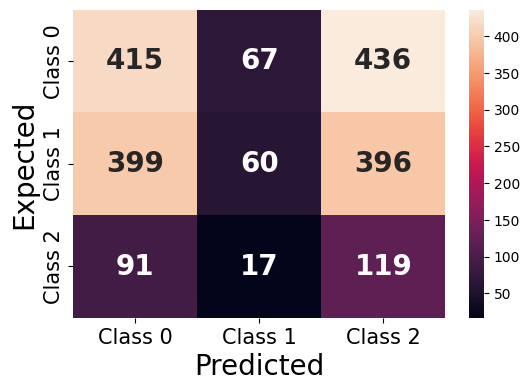

Normalized Confusion Matrix:


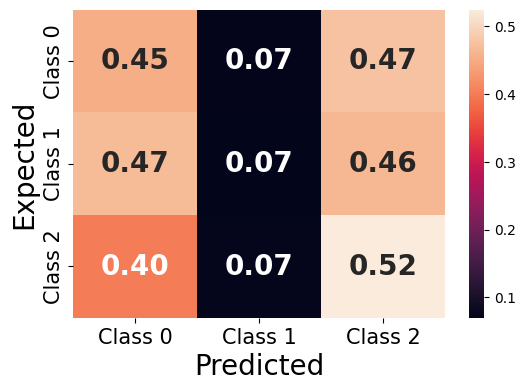

In [655]:
# Classification report
classification_report = classification_report(y_test, y_pred)
print('Classification Report:')
print(classification_report)

# Confusion matrix 
print('Confusion Matrix:')
_, ax = plt.subplots(figsize=(6, 4))
ax = sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', annot_kws={"size": 20, "weight": "bold"})  
labels = ['Class 0', 'Class 1', 'Class 2']
ax.set_xticklabels(labels[::1], fontsize=15)
ax.set_yticklabels(labels[::1], fontsize=15)
ax.set_ylabel('Expected', fontsize=20)
ax.set_xlabel('Predicted', fontsize=20)
plt.show()

# Normalized Confusion matrix
print('Normalized Confusion Matrix:')
_, ax = plt.subplots(figsize=(6, 4))
cm = confusion_matrix(y_test, 
                      y_pred, 
                      normalize='true')
ax = sns.heatmap(cm, annot=True, fmt='.2f', annot_kws={"size": 20, "weight": "bold"})
labels = ['Class 0', 'Class 1', 'Class 2']
ax.set_xticklabels(labels[::1], fontsize=15)
ax.set_yticklabels(labels[::1], fontsize=15)
ax.set_ylabel('Expected', fontsize=20)
ax.set_xlabel('Predicted', fontsize=20)
plt.show()

## Model 2

In [765]:
import transformers
from transformers import DistilBertTokenizer, TFDistilBertModel, DistilBertConfig
from transformers import TFDistilBertForSequenceClassification
from transformers import TextClassificationPipeline

from tqdm import tqdm # Progress Bar

import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

print('TensorFlow: {}'.format(tf.__version__))
# To check if we have access to the GPU on my Apple M1 Mac
print("TensorFlow has access to the following devices:")
for device in tf.config.list_physical_devices():
    print(f"· {device}")

TensorFlow: 2.12.0
TensorFlow has access to the following devices:
· PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')
· PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


### Load data

In [658]:
DATA_ROOT = './input/'
GAP_DATA_FOLDER = os.path.join(DATA_ROOT, 'gap-coreference-master')
GAP_DATA_FOLDER

train_df_path = os.path.join(GAP_DATA_FOLDER, 'gap-development.tsv')
test_df_path = os.path.join(GAP_DATA_FOLDER, 'gap-test.tsv')
val_df_path = os.path.join(GAP_DATA_FOLDER, 'gap-validation.tsv')

train_df2 = pd.read_csv(train_df_path, sep='\t') # train_df
test_df2 = pd.read_csv(test_df_path, sep='\t')
val_df2 = pd.read_csv(val_df_path, sep='\t')

### Preprocessing Pipeline

In [700]:
# Text Cleaning Functions

def select_imp_features(df):
    imp_features = ["Text", "Pronoun", "Pronoun-offset", "A", "A-offset", "B", "B-offset"]
    target_col = ["A-coref", "B-coref"]
    df = df[imp_features + target_col]
    return df 

def lower_case(df):
    df.loc[:, "text_clean"] = df["Text"].apply(lambda x: x.lower())
    df.loc[:, "Pronoun"] = df["Pronoun"].apply(lambda x: x.lower())
    df.loc[:, "A"] = df["A"].apply(lambda x: x.lower())
    df.loc[:, "B"] = df["B"].apply(lambda x: x.lower())

def expand_contractions(df):
    df.loc[:, "text_clean"] = df["text_clean"].apply(lambda x: contractions.fix(x))

def remove_non_ascii_characters(df, col='text_clean'):
    df.loc[:, col] = df[col].apply(lambda text: re.sub(r'[^\x00-\x7f]', r'', text)) # get rid of non-characters and whitespace
    return df

def remove_punctuations(df, col='text_clean'):
    """
     - str.maketrans('', '', string.punctuation) crea un traductor utilizando maketrans 
       que mapea los caracteres de puntuación a None, es decir, los elimina.
     - string.punctuation es una cadena predefinida en el módulo string que contiene todos 
       los caracteres de puntuación.
     - text.translate(translator) aplica el traductor al texto, reemplazando las puntuaciones 
       con caracteres vacíos, lo que efectivamente las elimina.
    """
    df.loc[:, col] = df[col].apply(lambda text: text.translate(str.maketrans('', '', string.punctuation)))
    # return re.sub(r'[]!"$%&\'()*+,./:;=#@?[\\^_`{|}~-]+', "", text)
    return df

# Orquestación secuencial de la limpieza de texto
def text_cleaning(df):
    # Crear una copia del DataFrame:
        # todas las modificaciones se realicen en una copia independiente 
        # y no afectan al DataFrame original.
    df = df.copy()  
    # text cleaning functions
    df = select_imp_features(df)
    lower_case(df)
    expand_contractions(df)
    df = remove_non_ascii_characters(df)
    df = remove_punctuations(df)
    return df

# Converting target to binary
def encode_target(df, target_1="A-coref", target_2="B-coref"):
    """
    Debemos codificar las etiquetas de clase de las variables objetivo 
    (A-coref y B-coref) para asegurar la compatibilidad con los modelos.
    Dabido a que tenemos clases binarias, usaremos el LabelEncoder:
        - False = 0
        - True = 1
    """
    le = preprocessing.LabelEncoder()
    df[target_1] = le.fit_transform(df[target_1])
    df[target_2] = le.fit_transform(df[target_2])

    return df

# CREAR COLUMNA TARGET DEFINITIVA
# Añadir 3a condición: pronombre no hace referencia a ninguno de los nombres propuestos
def add_none_coref_column(df):
    """
    Puede haber casos en los que la respuesta sea A-coref == False y B-coref == False, 
    lo que indica que el pronombre no hace referencia a ninguno de los nombres propuestos. 
    """
    # Obtener las columnas A-coref y B-coref del dataset de entrenamiento
    a_coref = df['A-coref'].values
    b_coref = df['B-coref'].values

    # Crear la tercera columna para representar la clase "None"
    none_coref = np.where((a_coref == 0) & (b_coref == 0), 1, 0)

    # Agregar la columna "None-coref" al dataset de entrenamiento
    df['None-coref'] = none_coref

    return df

# Crear la columna target
def get_target(row):
    """
    Creamos la columna target definitiva donde asignamos:
    - `0`: si el pronombre hace referencia al nombre A.
    - `1`: si el pronombre hace referencia al nombre B.
    - `2`: si el pronombre no hace referencia a ninguno de los dos nombres propuestos. 
    """
    if row['A-coref'] == 1:
        return 0
    elif row['B-coref'] == 1:
        return 1
    else:
        return 2

def multiclass_target(df):
    """
    Crea la columna target definitiva.
    Agrega la columna "None-coref" y "target" al df, 
    donde la columna "target" contendrá los valores 0, 1 o 2 
    dependiendo de si el pronombre hace referencia al nombre A, B 
    o a ninguno de los dos nombres propuestos.
    """
    df = df.copy()
    # Añadir la columna None-coref al df
    df = add_none_coref_column(df)
    # Crear la columna target 
    df['target'] = df.apply(get_target, axis=1)

    return df

def preprocess_dataset_distilbert(df):
    """
    Realiza el preprocesamiento completo del dataset.
    Devuelve el df preprocesado. 
    """
    
    # Text Cleaning
    df_cleaned = text_cleaning(df)

    # Converting target to binary
    df_cleaned = encode_target(df_cleaned, 
                               target_1="A-coref", 
                               target_2="B-coref")

    # Creamos la columna target definitiva
    df_final = multiclass_target(df_cleaned)

    # Columnas de interés
    df_final = df_final[['text_clean', 'Pronoun', 'A', 'B', 'target']]

    return df_final

#### Train set preprocessing

In [701]:
# Preprocess the TRAIN set
train_df2_prep = preprocess_dataset_distilbert(train_df2)

In [702]:
train_df2_prep.head(3)

,text_clean,Pronoun,A,B,target
0,zoe telford played the police officer girlfri...,her,cheryl cassidy,pauline,0
1,he grew up in evanston illinois the second old...,his,mackenzie,bernard leach,0
2,he had been reelected to congress but resigned...,his,angeloz,de la sota,1


#### Validation set preprocessing

In [703]:
# Preprocess the VALIDATION set
val_df2_prep = preprocess_dataset_distilbert(val_df2)

In [704]:
val_df2_prep.head(3)

,text_clean,Pronoun,A,B,target
0,he admitted making four trips to china and pla...,him,jose de venecia jr,abalos,2
1,kathleen nott was born in camberwell london he...,she,ellen,kathleen,1
2,when she returns to her hotel room a liberian ...,his,jason scott lee,danny,1


#### Test set preprocessing

In [705]:
# Preprocess the TEST set
test_df2_prep = preprocess_dataset_distilbert(test_df2)

In [706]:
test_df2_prep.head(3)

,text_clean,Pronoun,A,B,target
0,upon their acceptance into the kontinental hoc...,his,bob suter,dehner,1
1,between the years 19791981 river won four loca...,him,alonso,alfredo di st*fano,0
2,though his emigration from the country has aff...,he,ali aladhadh,saddam,0


### DistilBERT base model (uncased)

- https://huggingface.co/distilbert-base-uncased

In [731]:
# Nombre del modelo
MODEL_NAME = 'distilbert-base-cased'

In [867]:
# Cargar el modelo preentrenado DistilBERT
model_distilbert = TFDistilBertModel.from_pretrained(MODEL_NAME)

Some layers from the model checkpoint at distilbert-base-cased were not used when initializing TFDistilBertModel: ['vocab_transform', 'activation_13', 'vocab_projector', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [ ]:
# Definimos el tokenizer
"""
DistilBertTokenizer generará input IDS y attention mask como outputs.
Esto es lo que requiere el modelo como input. 
Cuando pasamos el texto por el tokenizer, el output generado estará en el 
el formato esperado por la arquitectura DistilBERT.
"""
tokenizer = DistilBertTokenizer.from_pretrained(MODEL_NAME)

In [730]:
# Finding the max token sequence in the training set
max_val = 0
for sent in (train_df2_prep['text_clean'].tolist() + train_df2_prep['text_clean'].tolist() + val_df2_prep['text_clean'].tolist()):
    try:
        sent_tok_len = len(tokenizer.tokenize(sent))
        max_val = sent_tok_len if (sent_tok_len > max_val) else max_val
    except:
        pass
    
print(f"The maximum amount of tokens in the dataset is {max_val}")

The maximum amount of tokens in the dataset is 251


- Estableceré la longitud máxima y la entrada para el modelo de deep learning en 253.
     - Max token length + 2 for special characters [CLS] and [SEP])


In [841]:
# Finding the max token sequence in the training set
max_val = 0
for sent in (train_df2_prep['Pronoun'].tolist() + train_df2_prep['Pronoun'].tolist() + val_df2_prep['Pronoun'].tolist()):
    try:
        sent_tok_len = len(tokenizer.tokenize(sent))
        max_val = sent_tok_len if (sent_tok_len > max_val) else max_val
    except:
        pass
    
print(f"The maximum amount of tokens in the dataset is {max_val}")

The maximum amount of tokens in the dataset is 1


In [840]:
# Finding the max token sequence in the training set
max_val = 0
for sent in (train_df2_prep['A'].tolist() + train_df2_prep['A'].tolist() + val_df2_prep['A'].tolist()):
    try:
        sent_tok_len = len(tokenizer.tokenize(sent))
        max_val = sent_tok_len if (sent_tok_len > max_val) else max_val
    except:
        pass
    
print(f"The maximum amount of tokens in the dataset is {max_val}")

The maximum amount of tokens in the dataset is 17


In [839]:
# Finding the max token sequence in the training set
max_val = 0
for sent in (train_df2_prep['B'].tolist() + train_df2_prep['B'].tolist() + val_df2_prep['B'].tolist()):
    try:
        sent_tok_len = len(tokenizer.tokenize(sent))
        max_val = sent_tok_len if (sent_tok_len > max_val) else max_val
    except:
        pass
    
print(f"The maximum amount of tokens in the dataset is {max_val}")

The maximum amount of tokens in the dataset is 17


In [849]:
MAX_LENGTH = 251+2
MAX_Pronoun_LENGTH = 1+2
MAX_A_LENGTH = 17+2
MAX_B_LENGTH = 17+2

In [739]:
tokenizer = DistilBertTokenizer.from_pretrained(MODEL_NAME,  
                                                add_special_tokens=True,
                                                max_length=MAX_LENGTH, 
                                                pad_to_max_length=True)

def tokenize(sentences, tokenizer):
    input_ids, input_masks, input_segments = [], [], []
    for sentence in tqdm(sentences):
        inputs = tokenizer.encode_plus(sentence, 
                                       add_special_tokens=True, 
                                       max_length=MAX_LENGTH, 
                                       pad_to_max_length=True, 
                                       return_attention_mask=True, 
                                       return_token_type_ids=True, 
                                       truncation=True)
                                       
        input_ids.append(inputs['input_ids'])
        input_masks.append(inputs['attention_mask'])
        input_segments.append(inputs['token_type_ids'])        
        
    return np.asarray(input_ids, dtype='int32'), np.asarray(input_masks, dtype='int32')


In [830]:
# feature columns
feature_cols = ['text_clean', 'Pronoun', 'A', 'B']

X_train2 = [tokenize(train_df2_prep[col], tokenizer) for col in feature_cols]
X_val2 = [tokenize(val_df2_prep[col], tokenizer) for col in feature_cols]
X_test2 = [tokenize(test_df2_prep[col], tokenizer) for col in feature_cols]


100%|██████████| 2000/2000 [00:00<00:00, 7235.97it/s]


In [793]:
# target column
target_cols = 'target'

# y_train, y_val and y_test
y_train2 = train_df2_prep[target_cols].values
y_val2 = val_df2_prep[target_cols].values
y_test2 = test_df2_prep[target_cols].values

Looking at entry


In [757]:
index_num = 0 # primer texto

print(train_df2_prep.loc[index_num]['target'], '\n')

print(train_df2_prep['text_clean'][index_num], '\n')

temp_tokens = tokenizer.tokenize(train_df2_prep['text_clean'][index_num])
temp_ids = tokenizer.encode(train_df2_prep['text_clean'][index_num])

print('ID\'s', 'Input Tokens', sep='\t')
for i in range(len(temp_ids)):
    if i == 0:
        print(temp_ids[i], '[CLS]', sep='\t')
        continue
    if i == len(temp_ids)-1:
        print(temp_ids[i], '[SEP]', sep='\t')
        break
    print(temp_ids[i], temp_tokens[i-1], sep='\t')

0 

zoe telford  played the police officer girlfriend of simon maggie dumped by simon in the final episode of series 1 after he slept with jenny and is not seen again phoebe thomas played cheryl cassidy paulines friend and also a year 11 pupil in simons class dumped her boyfriend following simons advice after he would not have sex with her but later realised this was due to him catching crabs off her friend pauline 

ID's	Input Tokens
101	[CLS]
195	z
7745	##oe
21359	te
9654	##lf
6944	##ord
1307	played
1103	the
2021	police
2575	officer
6124	girlfriend
1104	of
27466	si
7130	##mon
12477	ma
9705	##gg
1663	##ie
14632	dumped
1118	by
27466	si
7130	##mon
1107	in
1103	the
1509	final
2004	episode
1104	of
1326	series
122	1
1170	after
1119	he
7362	slept
1114	with
179	j
1424	##en
3382	##ny
1105	and
1110	is
1136	not
1562	seen
1254	again
185	p
10061	##hoe
3962	##be
24438	th
7903	##oma
1116	##s
1307	played
22572	ch
5075	##ery
1233	##l
11019	ca
19828	##ssi
3810	##dy
185	p
18318	##aul
8515	##ines
1910	f

- La columna 'target' muestra el valor 0 en este caso (pronombre hace referencia al nombre A), y la columna 'text_clean' contiene un texto largo que ha sido tokenizado utilizando el tokenizer. 
- Los ID's de tokens y los tokens de entrada se imprimen junto con los correspondientes tokens especiales '[CLS]' y '[SEP]'.






### Creating the model


##### chatgpt

In [870]:
MAX_LENGTH = 251+2
MAX_Pronoun_LENGTH = 1+2
MAX_A_LENGTH = 17+2
MAX_B_LENGTH = 17+2 

unique_words = set()
for text in train_df2_prep['text_clean']:
    unique_words.update(text.split())
# número total de palabras únicas
VOCAB_SIZE = len(unique_words) # 22246

EMBEDDING_DIM = 128
LSTM_UNITS = 50


In [871]:
from transformers import TFDistilBertModel, DistilBertTokenizer
from tensorflow.keras.layers import Input, Dense, Concatenate
from tensorflow.keras.models import Model
import numpy as np
from tqdm import tqdm


def tokenize(sentences, tokenizer):
    input_ids, attention_masks = [], []
    for sentence in tqdm(sentences):
        inputs = tokenizer.encode_plus(sentence,
                                       add_special_tokens=True,
                                       max_length=MAX_LENGTH,
                                       pad_to_max_length=True,
                                       return_attention_mask=True,
                                       truncation=True)

        input_ids.append(inputs['input_ids'])
        attention_masks.append(inputs['attention_mask'])

    return np.asarray(input_ids, dtype='int32'), np.asarray(attention_masks, dtype='int32')


# Feature columns
feature_cols = ['text_clean', 'Pronoun', 'A', 'B']

X_train2 = [tokenize(train_df2_prep[col], tokenizer) for col in feature_cols]
X_val2 = [tokenize(val_df2_prep[col], tokenizer) for col in feature_cols]
X_test2 = [tokenize(test_df2_prep[col], tokenizer) for col in feature_cols]

# Target column
target_col = 'target'

# y_train, y_val, y_test
y_train2 = train_df2_prep[target_col].values
y_val2 = val_df2_prep[target_col].values
y_test2 = test_df2_prep[target_col].values

# Definir las entradas para el modelo
input_text = Input(shape=(MAX_LENGTH,), name='text_input')
input_pronoun = Input(shape=(MAX_LENGTH,), name='pronoun_input')
input_A = Input(shape=(MAX_LENGTH,), name='A_input')
input_B = Input(shape=(MAX_LENGTH,), name='B_input')

# Obtener las representaciones de las entradas utilizando el modelo DistilBERT
text_representation = model_distilbert(input_text)[0][:, 0, :]  # Obtener solo la representación del token [CLS]
pronoun_representation = model_distilbert(input_pronoun)[0][:, 0, :]
A_representation = model_distilbert(input_A)[0][:, 0, :]
B_representation = model_distilbert(input_B)[0][:, 0, :]

# Concatenar las representaciones de las entradas
concatenated = Concatenate()([text_representation, pronoun_representation, A_representation, B_representation])

# Capa densa para la salida final
output = Dense(3, activation='softmax')(concatenated)

# Definir el modelo con las entradas y la salida
model = Model(inputs=[input_text, input_pronoun, input_A, input_B], outputs=output)

model.summary()


100%|██████████| 2000/2000 [00:00<00:00, 7468.54it/s]


TypeError: Exception encountered when calling layer "tf_distil_bert_model_2" (type TFDistilBertModel).

in user code:

    File "/Users/bernatsort/Library/CloudStorage/OneDrive-LaSalle/1. MASTER_DS/NLP/nlp_env/lib/python3.9/site-packages/transformers/modeling_tf_utils.py", line 558, in run_call_with_unpacked_inputs  *
        return func(self, **unpacked_inputs)
    File "/Users/bernatsort/Library/CloudStorage/OneDrive-LaSalle/1. MASTER_DS/NLP/nlp_env/lib/python3.9/site-packages/transformers/models/distilbert/modeling_tf_distilbert.py", line 559, in call  *
        outputs = self.distilbert(
    File "/Users/bernatsort/Library/CloudStorage/OneDrive-LaSalle/1. MASTER_DS/NLP/nlp_env/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler  **
        raise e.with_traceback(filtered_tb) from None
    File "/var/folders/nt/_4rnz5m56f5_kxv2q50zn7mr0000gn/T/__autograph_generated_file0ubqdd5z.py", line 36, in tf__run_call_with_unpacked_inputs
        retval_ = ag__.converted_call(ag__.ld(func), (ag__.ld(self),), dict(**ag__.ld(unpacked_inputs)), fscope)
    File "/var/folders/nt/_4rnz5m56f5_kxv2q50zn7mr0000gn/T/__autograph_generated_fileb09wx1xq.py", line 92, in tf__call
        embedding_output = ag__.converted_call(ag__.ld(self).embeddings, (ag__.ld(input_ids),), dict(inputs_embeds=ag__.ld(inputs_embeds)), fscope)
    File "/var/folders/nt/_4rnz5m56f5_kxv2q50zn7mr0000gn/T/__autograph_generated_file_b259ify.py", line 33, in tf__call
        ag__.if_stmt(ag__.ld(input_ids) is not None, if_body, else_body, get_state, set_state, ('inputs_embeds',), 1)
    File "/var/folders/nt/_4rnz5m56f5_kxv2q50zn7mr0000gn/T/__autograph_generated_file_b259ify.py", line 28, in if_body
        inputs_embeds = ag__.converted_call(ag__.ld(tf).gather, (), dict(params=ag__.ld(self).weight, indices=ag__.ld(input_ids)), fscope)

    TypeError: Exception encountered when calling layer 'distilbert' (type TFDistilBertMainLayer).
    
    in user code:
    
        File "/Users/bernatsort/Library/CloudStorage/OneDrive-LaSalle/1. MASTER_DS/NLP/nlp_env/lib/python3.9/site-packages/transformers/modeling_tf_utils.py", line 558, in run_call_with_unpacked_inputs  *
            return func(self, **unpacked_inputs)
        File "/Users/bernatsort/Library/CloudStorage/OneDrive-LaSalle/1. MASTER_DS/NLP/nlp_env/lib/python3.9/site-packages/transformers/models/distilbert/modeling_tf_distilbert.py", line 409, in call  *
            embedding_output = self.embeddings(input_ids, inputs_embeds=inputs_embeds)  # (bs, seq_length, dim)
        File "/Users/bernatsort/Library/CloudStorage/OneDrive-LaSalle/1. MASTER_DS/NLP/nlp_env/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler  **
            raise e.with_traceback(filtered_tb) from None
        File "/var/folders/nt/_4rnz5m56f5_kxv2q50zn7mr0000gn/T/__autograph_generated_file_b259ify.py", line 33, in tf__call
            ag__.if_stmt(ag__.ld(input_ids) is not None, if_body, else_body, get_state, set_state, ('inputs_embeds',), 1)
        File "/var/folders/nt/_4rnz5m56f5_kxv2q50zn7mr0000gn/T/__autograph_generated_file_b259ify.py", line 28, in if_body
            inputs_embeds = ag__.converted_call(ag__.ld(tf).gather, (), dict(params=ag__.ld(self).weight, indices=ag__.ld(input_ids)), fscope)
    
        TypeError: Exception encountered when calling layer 'embeddings' (type TFEmbeddings).
        
        in user code:
        
            File "/Users/bernatsort/Library/CloudStorage/OneDrive-LaSalle/1. MASTER_DS/NLP/nlp_env/lib/python3.9/site-packages/transformers/models/distilbert/modeling_tf_distilbert.py", line 122, in call  *
                inputs_embeds = tf.gather(params=self.weight, indices=input_ids)
        
            TypeError: Value passed to parameter 'indices' has DataType float32 not in list of allowed values: int32, int64
        
        
        Call arguments received by layer 'embeddings' (type TFEmbeddings):
          • input_ids=tf.Tensor(shape=(None, 253), dtype=float32)
          • position_ids=None
          • inputs_embeds=None
          • training=False
    
    
    Call arguments received by layer 'distilbert' (type TFDistilBertMainLayer):
      • input_ids=tf.Tensor(shape=(None, 253), dtype=float32)
      • attention_mask=None
      • head_mask=None
      • inputs_embeds=None
      • output_attentions=False
      • output_hidden_states=False
      • return_dict=True
      • training=False


Call arguments received by layer "tf_distil_bert_model_2" (type TFDistilBertModel):
  • input_ids=tf.Tensor(shape=(None, 253), dtype=float32)
  • attention_mask=None
  • head_mask=None
  • inputs_embeds=None
  • output_attentions=None
  • output_hidden_states=None
  • return_dict=None
  • training=False

In [865]:
def tokenize(sentences, tokenizer):
    input_ids, attention_masks = [], []
    for sentence in tqdm(sentences):
        inputs = tokenizer.encode_plus(sentence,
                                       add_special_tokens=True,
                                       max_length=MAX_LENGTH,
                                       pad_to_max_length=True,
                                       return_attention_mask=True,
                                       truncation=True)

        input_ids.append(inputs['input_ids'])
        attention_masks.append(inputs['attention_mask'])

    return np.asarray(input_ids, dtype='int32'), np.asarray(attention_masks, dtype='int32')


# Feature columns
feature_cols = ['text_clean', 'Pronoun', 'A', 'B']

X_train2 = [tokenize(train_df2_prep[col], tokenizer) for col in feature_cols]
X_val2 = [tokenize(val_df2_prep[col], tokenizer) for col in feature_cols]
X_test2 = [tokenize(test_df2_prep[col], tokenizer) for col in feature_cols]

# Target column
target_col = 'target'

# y_train, y_val, y_test
y_train2 = train_df2_prep[target_col].values
y_val2 = val_df2_prep[target_col].values
y_test2 = test_df2_prep[target_col].values

# Definir las entradas para el modelo
input_text = Input(shape=(MAX_LENGTH,), name='text_input')
input_pronoun = Input(shape=(MAX_LENGTH,), name='pronoun_input')
input_A = Input(shape=(MAX_LENGTH,), name='A_input')
input_B = Input(shape=(MAX_LENGTH,), name='B_input')

# Obtener las representaciones de las entradas utilizando el modelo DistilBERT
text_representation = model(input_text)[0]
pronoun_representation = model(input_pronoun)[0]
A_representation = model(input_A)[0]
B_representation = model(input_B)[0]

# Concatenar las representaciones de las entradas
concatenated = Concatenate()([text_representation, pronoun_representation, A_representation, B_representation])

# Capa densa para la salida final
output = Dense(3, activation='softmax')(concatenated)

# Definir el modelo con las entradas y la salida
model = Model(inputs=[input_text, input_pronoun, input_A, input_B], outputs=output)

model.summary()

100%|██████████| 2000/2000 [00:00<00:00, 7151.46it/s]


AssertionError: Exception encountered when calling layer "model_1" (type Functional).

Could not compute output KerasTensor(type_spec=TensorSpec(shape=(None, 3), dtype=tf.float32, name=None), name='dense_2/Softmax:0', description="created by layer 'dense_2'")

Call arguments received by layer "model_1" (type Functional):
  • inputs=tf.Tensor(shape=(None, 253), dtype=float32)
  • training=None
  • mask=None

In [855]:
from keras.layers import Input, Embedding, LSTM, Dense, Concatenate
from keras.models import Model

# Definir las entradas para cada característica
input_text = Input(shape=(MAX_LENGTH,), name='text_input')
input_pronoun = Input(shape=(MAX_Pronoun_LENGTH,), name='pronoun_input')
input_A = Input(shape=(MAX_A_LENGTH,), name='A_input')
input_B = Input(shape=(MAX_B_LENGTH,), name='B_input')

# Embedding para cada característica
embedding_text = Embedding(VOCAB_SIZE, EMBEDDING_DIM)(input_text)
embedding_pronoun = Embedding(VOCAB_SIZE, EMBEDDING_DIM)(input_pronoun)
embedding_A = Embedding(VOCAB_SIZE, EMBEDDING_DIM)(input_A)
embedding_B = Embedding(VOCAB_SIZE, EMBEDDING_DIM)(input_B)

# LSTM para cada característica
lstm_text = LSTM(LSTM_UNITS)(embedding_text)
lstm_pronoun = LSTM(LSTM_UNITS)(embedding_pronoun)
lstm_A = LSTM(LSTM_UNITS)(embedding_A)
lstm_B = LSTM(LSTM_UNITS)(embedding_B)

# Concatenar las salidas de las LSTM
concatenated = Concatenate()([lstm_text, lstm_pronoun, lstm_A, lstm_B])

# Capa densa para la salida final
output = Dense(3, activation='softmax')(concatenated)

# Definir el modelo con múltiples entradas
model = Model(inputs=[input_text, input_pronoun, input_A, input_B], outputs=output)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text_input (InputLayer)        [(None, 253)]        0           []                               
                                                                                                  
 pronoun_input (InputLayer)     [(None, 3)]          0           []                               
                                                                                                  
 A_input (InputLayer)           [(None, 19)]         0           []                               
                                                                                                  
 B_input (InputLayer)           [(None, 19)]         0           []                               
                                                                                            

In [ ]:
# Creating a output directory to store the models weights:

### Create an output directory
output_dir = './model1_outputs'
if not os.path.exists(output_dir): ### If the file directory doesn't already exists,
    os.makedirs(output_dir) ### Make it please

In [ ]:
# Callbacks
model_checkpoint = ModelCheckpoint(filepath=output_dir+'/weights.{epoch:02d}.hdf5',
                                  save_weights_only=True)

early_stopping = EarlyStopping(patience=3, # Stop after 3 epochs of no improvement
                               monitor='val_loss', # Look at validation_loss
                               min_delta=0, # After 0 change
                               mode='min', # Stop when quantity has stopped decreasing
                               restore_best_weights=False, # Don't Restore the best weights
                               verbose=1) 

reduce_lr = ReduceLROnPlateau(monitor='val_loss', # Look at validation loss
                              min_lr=0.000001, # Lower bound of learning rate
                              patience=1, # Reduce after 1 with little change
                              mode='min', # Stop when quantity has stopped decreasing
                              factor=0.1, # Reduce by a factor of 1/10
                              min_delta=0.01, # Minimumn change needed
                              verbose=1)

In [862]:
X_train_text = X_train2[0]
X_train_pronoun = X_train2[1]
X_train_A = X_train2[2]
X_train_B = X_train2[3]


X_val_text = X_val2[0]
X_val_pronoun = X_val2[1]
X_val_A = X_val2[2]
X_val_B = X_val2[3]


In [864]:
# Compilar y entrenar el modelo
model.compile(loss='sparse_categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

history = model.fit({'text_input': X_train_text, 'pronoun_input': X_train_pronoun, 'A_input': X_train_A, 'B_input': X_train_B},
                    y_train2,
                    epochs=10,
                    batch_size=32,
                    validation_data=({'text_input': X_val_text, 'pronoun_input': X_val_pronoun, 'A_input': X_val_A, 'B_input': X_val_B},
                                     y_val2),
                    callbacks=[model_checkpoint, early_stopping, reduce_lr])

# history = model.fit([X_train_text, X_train_pronoun, X_train_A, X_train_B], 
#                     y_train2,
#                     epochs=10, 
#                     batch_size=32, 
#                     validation_data=([X_val_text, X_val_pronoun, X_val_A, X_val_B], 
#                                     y_val2),
#                     callbacks=[model_checkpoint, early_stopping, reduce_lr])

              
# history = model.fit(X_train2, 
#                     y_train2,
#                     epochs=10, 
#                     batch_size=32, 
#                     validation_data=(X_val2, y_val2),
#                     callbacks=[model_checkpoint, early_stopping, reduce_lr])


# model.compile(loss='sparse_categorical_crossentropy', 
#               optimizer='adam', 
#               metrics=['accuracy'])

# history = model.fit(X_train2, 
#                     y_train2, 
#                     epochs = 10,
#                     batch_size=32, 
#                     validation_data=(X_val2, y_val2), 
#                     callbacks=[model_checkpoint, early_stopping, reduce_lr])

Epoch 1/10


ValueError: in user code:

    File "/Users/bernatsort/Library/CloudStorage/OneDrive-LaSalle/1. MASTER_DS/NLP/nlp_env/lib/python3.9/site-packages/keras/engine/training.py", line 1284, in train_function  *
        return step_function(self, iterator)
    File "/Users/bernatsort/Library/CloudStorage/OneDrive-LaSalle/1. MASTER_DS/NLP/nlp_env/lib/python3.9/site-packages/keras/engine/training.py", line 1268, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/bernatsort/Library/CloudStorage/OneDrive-LaSalle/1. MASTER_DS/NLP/nlp_env/lib/python3.9/site-packages/keras/engine/training.py", line 1249, in run_step  **
        outputs = model.train_step(data)
    File "/Users/bernatsort/Library/CloudStorage/OneDrive-LaSalle/1. MASTER_DS/NLP/nlp_env/lib/python3.9/site-packages/keras/engine/training.py", line 1050, in train_step
        y_pred = self(x, training=True)
    File "/Users/bernatsort/Library/CloudStorage/OneDrive-LaSalle/1. MASTER_DS/NLP/nlp_env/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/bernatsort/Library/CloudStorage/OneDrive-LaSalle/1. MASTER_DS/NLP/nlp_env/lib/python3.9/site-packages/keras/engine/input_spec.py", line 219, in assert_input_compatibility
        raise ValueError(

    ValueError: Layer "model_1" expects 4 input(s), but it received 8 input tensors. Inputs received: [<tf.Tensor 'IteratorGetNext:6' shape=(None, 253) dtype=int32>, <tf.Tensor 'IteratorGetNext:7' shape=(None, 253) dtype=int32>, <tf.Tensor 'IteratorGetNext:4' shape=(None, 253) dtype=int32>, <tf.Tensor 'IteratorGetNext:5' shape=(None, 253) dtype=int32>, <tf.Tensor 'IteratorGetNext:0' shape=(None, 253) dtype=int32>, <tf.Tensor 'IteratorGetNext:1' shape=(None, 253) dtype=int32>, <tf.Tensor 'IteratorGetNext:2' shape=(None, 253) dtype=int32>, <tf.Tensor 'IteratorGetNext:3' shape=(None, 253) dtype=int32>]


##### kaggle

In [761]:
# Creating the model 

config = DistilBertConfig.from_pretrained(MODEL_NAME, 
                                          output_hidden_states=True, 
                                          output_attentions=True)

DistilBERT = TFDistilBertModel.from_pretrained(MODEL_NAME, 
                                               config=config)

input_ids_in = tf.keras.layers.Input(shape=(MAX_LENGTH,), 
                                     name='input_token', 
                                     dtype='int32')

input_masks_in = tf.keras.layers.Input(shape=(MAX_LENGTH,), 
                                       name='masked_token', 
                                       dtype='int32') 

embedding_layer = DistilBERT(input_ids = input_ids_in, attention_mask = input_masks_in)[0]
X = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True))(embedding_layer)
X = tf.keras.layers.GlobalMaxPool1D()(X)
X = tf.keras.layers.Dense(64, activation='relu')(X)
X = tf.keras.layers.Dropout(0.2)(X)
X = tf.keras.layers.Dense(3, activation='softmax')(X)

model = tf.keras.Model(inputs=[input_ids_in, input_masks_in], outputs = X)

for layer in model.layers[:3]:
    layer.trainable = False

model.summary()

Some layers from the model checkpoint at distilbert-base-cased were not used when initializing TFDistilBertModel: ['vocab_transform', 'activation_13', 'vocab_projector', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_token (InputLayer)       [(None, 253)]        0           []                               
                                                                                                  
 masked_token (InputLayer)      [(None, 253)]        0           []                               
                                                                                                  
 tf_distil_bert_model (TFDistil  TFBaseModelOutput(l  65190912   ['input_token[0][0]',            
 BertModel)                     ast_hidden_state=(N               'masked_token[0][0]']           
                                one, 253, 768),                                                   
                                 hidden_states=((No                                           

In [763]:
# Creating a output directory to store the models weights:

### Create an output directory
output_dir = './model1_outputs'
if not os.path.exists(output_dir): ### If the file directory doesn't already exists,
    os.makedirs(output_dir) ### Make it please


In [766]:
# Callbacks
model_checkpoint = ModelCheckpoint(filepath=output_dir+'/weights.{epoch:02d}.hdf5',
                                  save_weights_only=True)

early_stopping = EarlyStopping(patience=3, # Stop after 3 epochs of no improvement
                               monitor='val_loss', # Look at validation_loss
                               min_delta=0, # After 0 change
                               mode='min', # Stop when quantity has stopped decreasing
                               restore_best_weights=False, # Don't Restore the best weights
                               verbose=1) 

reduce_lr = ReduceLROnPlateau(monitor='val_loss', # Look at validation loss
                              min_lr=0.000001, # Lower bound of learning rate
                              patience=1, # Reduce after 1 with little change
                              mode='min', # Stop when quantity has stopped decreasing
                              factor=0.1, # Reduce by a factor of 1/10
                              min_delta=0.01, # Minimumn change needed
                              verbose=1)

#### Compile and train the model



In [831]:
model.compile(loss='sparse_categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

history = model.fit(X_train2, 
                    y_train2, 
                    epochs = 10,
                    batch_size=32, 
                    validation_data=(X_val2, y_val2), 
                    callbacks=[model_checkpoint, early_stopping, reduce_lr])




Epoch 1/10


2023-06-16 22:25:16.874606: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


ValueError: in user code:

    File "/Users/bernatsort/Library/CloudStorage/OneDrive-LaSalle/1. MASTER_DS/NLP/nlp_env/lib/python3.9/site-packages/keras/engine/training.py", line 1284, in train_function  *
        return step_function(self, iterator)
    File "/Users/bernatsort/Library/CloudStorage/OneDrive-LaSalle/1. MASTER_DS/NLP/nlp_env/lib/python3.9/site-packages/keras/engine/training.py", line 1268, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/bernatsort/Library/CloudStorage/OneDrive-LaSalle/1. MASTER_DS/NLP/nlp_env/lib/python3.9/site-packages/keras/engine/training.py", line 1249, in run_step  **
        outputs = model.train_step(data)
    File "/Users/bernatsort/Library/CloudStorage/OneDrive-LaSalle/1. MASTER_DS/NLP/nlp_env/lib/python3.9/site-packages/keras/engine/training.py", line 1050, in train_step
        y_pred = self(x, training=True)
    File "/Users/bernatsort/Library/CloudStorage/OneDrive-LaSalle/1. MASTER_DS/NLP/nlp_env/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/bernatsort/Library/CloudStorage/OneDrive-LaSalle/1. MASTER_DS/NLP/nlp_env/lib/python3.9/site-packages/keras/engine/input_spec.py", line 219, in assert_input_compatibility
        raise ValueError(

    ValueError: Layer "model" expects 2 input(s), but it received 8 input tensors. Inputs received: [<tf.Tensor 'IteratorGetNext:0' shape=(None, 253) dtype=int32>, <tf.Tensor 'IteratorGetNext:1' shape=(None, 253) dtype=int32>, <tf.Tensor 'IteratorGetNext:2' shape=(None, 253) dtype=int32>, <tf.Tensor 'IteratorGetNext:3' shape=(None, 253) dtype=int32>, <tf.Tensor 'IteratorGetNext:4' shape=(None, 253) dtype=int32>, <tf.Tensor 'IteratorGetNext:5' shape=(None, 253) dtype=int32>, <tf.Tensor 'IteratorGetNext:6' shape=(None, 253) dtype=int32>, <tf.Tensor 'IteratorGetNext:7' shape=(None, 253) dtype=int32>]


In [832]:
len(X_train2)

4

In [833]:
len([X_train2[0], X_train2[1]])

2

In [834]:
X_train2[0]

(array([[  101,   195,  7745, ...,     0,     0,     0],
        [  101,  1119,  2580, ...,     0,     0,     0],
        [  101,  1119,  1125, ...,     0,     0,     0],
        ...,
        [  101,  5721,  1307, ...,     0,     0,     0],
        [  101,  1103,  4633, ...,     0,     0,     0],
        [  101, 20049,  1204, ...,     0,     0,     0]], dtype=int32),
 array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]], dtype=int32))

In [811]:
X_train2[0]

array([[ 101, 3087,  168, ...,    0,    0,    0],
       [ 101, 5096, 2728, ...,    0,    0,    0],
       [ 101,  138,  102, ...,    0,    0,    0],
       [ 101,  139,  102, ...,    0,    0,    0]], dtype=int32)

In [809]:
len(y_train2)

2000

In [774]:
len(X_train2)
X_train2

(array([[ 101, 3087,  168, ...,    0,    0,    0],
        [ 101, 5096, 2728, ...,    0,    0,    0],
        [ 101,  138,  102, ...,    0,    0,    0],
        [ 101,  139,  102, ...,    0,    0,    0]], dtype=int32),
 array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]], dtype=int32))

In [827]:
X_train2

(array([[ 101, 3087,  168, ...,    0,    0,    0],
        [ 101, 5096, 2728, ...,    0,    0,    0],
        [ 101,  138,  102, ...,    0,    0,    0],
        [ 101,  139,  102, ...,    0,    0,    0]], dtype=int32),
 array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]], dtype=int32))

In [813]:
y_train2

array([0, 0, 1, ..., 0, 0, 1])

# CACA

In [721]:
def process_data(texts, pronouns, candidates_a, candidates_b, targets):
    input_ids = []
    attention_masks = []
    token_type_ids = []

    for text, pronoun, candidate_a, candidate_b in zip(texts, pronouns, candidates_a, candidates_b):
        # Codificar el texto utilizando el tokenizador de DistilBERT
        encoded = tokenizer.encode_plus(
            text=text,
            text_pair=pronoun,
            candidate_a=candidate_a,
            candidate_b=candidate_b,
            add_special_tokens=True,
            max_length=128,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_token_type_ids=True
        )

        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
        token_type_ids.append(encoded['token_type_ids'])

    return np.array(input_ids), np.array(attention_masks), np.array(token_type_ids), np.array(targets)


In [722]:
# Procesar los datos de entrenamiento
train_input_ids, train_attention_masks, train_token_type_ids, train_targets = process_data(
    train_df2_prep['text_clean'],
    train_df2_prep['Pronoun'],
    train_df2_prep['A'],
    train_df2_prep['B'],
    train_df2_prep['target']
)

# Procesar los datos de validación
val_input_ids, val_attention_masks, val_token_type_ids, val_targets = process_data(
    val_df2_prep['text_clean'],
    val_df2_prep['Pronoun'],
    val_df2_prep['A'],
    val_df2_prep['B'],
    val_df2_prep['target']
)

# Procesar los datos de prueba
test_input_ids, test_attention_masks, test_token_type_ids, test_targets = process_data(
    test_df2_prep['text_clean'],
    test_df2_prep['Pronoun'],
    test_df2_prep['A'],
    test_df2_prep['B'],
    test_df2_prep['target']
)

# Crear conjuntos de datos TensorFlow
train_dataset = tf.data.Dataset.from_tensor_slices((train_input_ids, train_attention_masks, train_token_type_ids, train_targets)).batch(32)
val_dataset = tf.data.Dataset.from_tensor_slices((val_input_ids, val_attention_masks, val_token_type_ids, val_targets)).batch(32)
test_dataset = tf.data.Dataset.from_tensor_slices((test_input_ids, test_attention_masks, test_token_type_ids, test_targets)).batch(32)


Keyword arguments {'candidate_a': 'cheryl cassidy', 'candidate_b': 'pauline'} not recognized.
Keyword arguments {'candidate_a': 'cheryl cassidy', 'candidate_b': 'pauline'} not recognized.
Keyword arguments {'candidate_a': 'mackenzie', 'candidate_b': 'bernard leach'} not recognized.
Keyword arguments {'candidate_a': 'mackenzie', 'candidate_b': 'bernard leach'} not recognized.
Keyword arguments {'candidate_a': 'angeloz', 'candidate_b': 'de la sota'} not recognized.
Keyword arguments {'candidate_a': 'angeloz', 'candidate_b': 'de la sota'} not recognized.
Keyword arguments {'candidate_a': 'hell', 'candidate_b': 'henry rosenthal'} not recognized.
Keyword arguments {'candidate_a': 'hell', 'candidate_b': 'henry rosenthal'} not recognized.
Keyword arguments {'candidate_a': 'kitty oppenheimer', 'candidate_b': 'rivera'} not recognized.
Keyword arguments {'candidate_a': 'kitty oppenheimer', 'candidate_b': 'rivera'} not recognized.
Be aware, overflowing tokens are not returned for the setting you 

In [726]:
# Codificar los datos de entrada con el tokenizador de DistilBERT
def encode_text(text):
    """
    Codificar el texto de entrada de acuerdo con las especificaciones 
    necesarias para el modelo de DistilBERT.
    """
    return tokenizer.encode_plus(
        text, # string, a list of strings (tokenized string using the tokenize method) or a list of integers
        add_special_tokens=True,
        truncation=True, # trunca el texto si excede la longitud máxima
        padding=True, # pad to the longest sequence in the batch 
        return_attention_mask=True, # tensor binario que indica qué elementos de la secuencia de entrada son reales y cuáles son de relleno 
        return_token_type_ids=False,
        return_tensors='tf' # resultados en formato de tensores de TensorFlow
    )

In [727]:
# Codificar los datos de entrada
def encode_data(data):
    X_text = data['text_clean'].apply(encode_text)
    X_pronoun = data['Pronoun'].apply(encode_text)
    X_name_A = data['A'].apply(encode_text)
    X_name_B = data['B'].apply(encode_text)
    
    X = {
        'input_ids_text': tf.squeeze(X_text['input_ids']),
        'attention_mask_text': tf.squeeze(X_text['attention_mask']),
        'input_ids_pronoun': tf.squeeze(X_pronoun['input_ids']),
        'attention_mask_pronoun': tf.squeeze(X_pronoun['attention_mask']),
        'input_ids_A': tf.squeeze(X_name_A['input_ids']),
        'attention_mask_A': tf.squeeze(X_name_A['attention_mask']),
        'input_ids_B': tf.squeeze(X_name_B['input_ids']),
        'attention_mask_B': tf.squeeze(X_name_B['attention_mask']),
    }
    
    y = data['target']
    
    return X, y

In [728]:
# Codificar los datos de entrenamiento
X_train2, y_train2 = encode_data(train_df2_prep)
# Crear dataset de entrenamiento
train_dataset = tf.data.Dataset.from_tensor_slices((X_train2, y_train2))

# Codificar los datos de validación
X_val2, y_val2 = encode_data(val_df2_prep)
# Crear dataset de validación
val_dataset = tf.data.Dataset.from_tensor_slices((X_val2, y_val2))

# Codificar los datos de prueba
X_test2, y_test2 = encode_data(test_df2_prep)
# Crear dataset de test
test_dataset = tf.data.Dataset.from_tensor_slices((X_test2, y_test2 ))

KeyError: 'input_ids'

In [ ]:
# Codificar los datos de entrada para entrenamiento

# Genera los tokens codificados y las máscaras de atención para cada texto de entrenamiento
X_train2 = train_df2_prep['text_clean'].apply(encode_text)

X_train2 = tf.data.Dataset.from_tensor_slices(({
    'input_ids': tf.squeeze(X_train2['input_ids']),
    'attention_mask': tf.squeeze(X_train2['attention_mask'])}, 
    train_df2_prep[['A-offset', 'B-offset']]))

# Extrae las etiquetas de train set 
y_train2 = train_df2_prep['target']

In [691]:
train_df2_prep.head(1)

,Text,Pronoun,Pronoun-offset,A,A-offset,B,B-offset,A-coref,B-coref,text_clean,None-coref,target
0,Zoe Telford -- played the police officer girlf...,her,274,cheryl cassidy,191,pauline,207,1,0,zoe telford played the police officer girlfri...,0,0


In [668]:


train_encodings = tokenizer(X_train, 
                            truncation = True, 
                            padding = True # pad to the longest sequence in the batch 
                            )

val_encodings = tokenizer(val_texts, 
                          truncation = True, 
                          padding = True # pad to the longest sequence in the batch 
                          )

ValueError: text input must of type `str` (single example), `List[str]` (batch or single pretokenized example) or `List[List[str]]` (batch of pretokenized examples).

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    y_train
))


val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    y_train
))